<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# Transformers Text Classifier Training with Hyperparameter Tuning

by Fabian Märki

## Summary
The aim of this notebook is to finetune a Transformers based text classifier for either binary, multi-class or multi-label classification (with the aim to provid a script like notebook for rapid prototyping). Additionally, it showcases how to do a hyperparameter search using Huggingface's Trainer.

## Links
- [Enabling GPU on Google Colab](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm)
- [Hyperparameter Search using Trainer API](https://huggingface.co/docs/transformers/hpo_train)
- [Hyperparameter Optimization](https://huggingface.co/docs/setfit/how_to/hyperparameter_optimization)
- [Hyperparameter Search with Transformers and Ray Tune](https://huggingface.co/blog/ray-tune)
- [Notebook on Hyperparameter Tuning](https://github.com/huggingface/notebooks/blob/main/examples/text_classification.ipynb)

This notebook does not contain assigments: <font color='red'>Enjoy</font>

<font color='red'>However, you could try to run this notebook with your own data.</font>

<a href="https://colab.research.google.com/github/markif/2024_HS_Advanced_NLP_LAB/blob/master/01_a_Transformers_Text_Classifier_Training_with_Hyperparameter_Tuning.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer) supports different hyperparameter search backends: [optuna](https://optuna.org), [sigopt](https://sigopt.org), [raytune](https://docs.ray.io/en/latest/tune/index.html) and [wandb](https://wandb.ai/site/sweeps).

We will use optuna.

In [1]:
%%capture

!pip install optuna
!pip install transformers datasets evaluate

In [2]:
%%capture

!pip install 'fhnw-nlp-utils>=0.9.10,<0.10.0'

from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import load_dataframe

import pandas as pd
import numpy as np

**Make sure that a GPU is available (see [here](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm))!!!**

In [3]:
from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.system import system_info

set_log_level()
print(system_info())

2024-10-02 20:34:20.913884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 20:34:20.929777: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 20:34:20.934458: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


OS name: posix
Platform name: Linux
Platform release: 6.8.0-40-generic
Python version: 3.11.0rc1
CPU cores: 6
RAM: 31.11GB total and 22.28GB available
Tensorflow version: 2.17.0
GPU is available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 8192MiB


/usr/local/lib/python3.11/dist-packages/pynvml/smi.py:5: FutureWarning: The pynvml.smi module is deprecated and will be removed in the next release of pynvml. Please use pynvml_utils:
(e.g. `from pynvml_utils import nvidia_smi`)
  warnings.warn(


We use the [MultiEURLEX dataset](https://huggingface.co/datasets/coastalcph/multi_eurlex). MultiEURLEX can be used for legal topic classification, a multi-label classification task where legal documents need to be assigned to their topics. The original dataset comprises documents in 23 languages. The dataset used in this notebook only contains german labels.

In [4]:
download("https://drive.switch.ch/index.php/s/whIMDgzRRsuCtLJ/download", "data/eurlex_de.parq")
data = load_dataframe("data/eurlex_de.parq")

In [5]:
data.head(3)

,celex_id,text,multi-label_label,multi-class_label,binary_label
0,32006D0213,ENTSCHEIDUNG DER KOMMISSION\nvom 6. März 2006\...,"[industrie, umwelt, produktion, technologie un...",handel,handel
1,32003R1330,Verordnung (EG) Nr. 1330/2003 der Kommission\n...,"[finanzwesen, agrarerzeugnisse und lebensmittel]",agrarerzeugnisse und lebensmittel,others
2,32003R1786,Verordnung (EG) Nr. 1786/2003 des Rates\nvom 2...,"[handel, wirtschaft, land- und forstwirtschaft...",handel,handel


The original labels are stored in the column `multi-label_label`. This column is meant for **multi-label** classification. The original dataset has been modified that it also contains a `multi-class_label` and a `binary_label` column. The former is meant for **multi-class** classification and contains the most frequent label from the `multi-label_label` and the later is meant for **binary** classification and contains either the most frequent label *handel* or is assigned to the class *others*.

The `params` dictionary allows us to use the same code for all three classification types (i.e. it allows us to switch code blockes based on the classification type).

We will focus on a multi-label classification.

In [6]:
from fhnw.nlp.utils.transformers import get_compute_device

params = {
    "verbose": True,
    "X_column_name": "text",
    "y_column_name": "multi-label_label",
    #"y_column_name": "multi-class_label",
    #"y_column_name": "binary_label",
    "y_column_name_prediction": "prediction",
    "compute_device": get_compute_device(),
    "transformer_model_name": "distilbert-base-multilingual-cased",
    #"transformer_model_name": "bert-base-multilingual-uncased",
    # modify batch_size in case you experience memory issues
    "batch_size": 8,
    "train_test_split_size": 0.2,
    "pipeline_name": "eurlex-topic-classifier",
}

params["label_column_name"] = "labels" if params["y_column_name"] == "multi-label_label" else "label" 

In case you experience issues with auto (down-)loading the tokenizer/model, you can download the tokenizer/model files into a local folder and load the tokenizer/model from there (this might especially be beneficial with LLMs - see also [here](https://huggingface.co/docs/huggingface_hub/de/guides/download)). 

In [7]:
if True:
    from huggingface_hub import snapshot_download
    params["local_dir"] = "models/huggingface/"

    # only download pytorch model and ignore TF (.h5), Flax (.msgpack) and ONNX (.onnx - open format built to represent machine learning models)
    snapshot_download(repo_id=params["transformer_model_name"], local_dir=params["local_dir"]+params["transformer_model_name"], ignore_patterns=["*.onnx", "*.msgpack", "*.h5"])

    # set the model name to the local folder
    params["transformer_model_name"]=params["local_dir"]+params["transformer_model_name"]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
from fhnw.nlp.utils.transformers import dataframes_to_dataset

dataset = dataframes_to_dataset(params, data)

Inferred classification type: multi-label
Inferred classification type: multi-label
38945 train examples
26048 test examples
Inferred classification type: multi-label
13008 train examples
13040 test examples


Casting the dataset:   0%|          | 0/38945 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/13008 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/13040 [00:00<?, ? examples/s]

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 38945
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 13040
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 13008
    })
})

Specify different parameters used for the transformers model.

In [10]:
from fhnw.nlp.utils.params import get_classification_type

classification_type = get_classification_type(params, data) # either "binary", "multi-class" or "multi-label"
params["classification_type"] = classification_type
problem_type = "multi_label_classification" if classification_type == "multi-label" else "single_label_classification" 
classlabel = dataset["train"].features[params["label_column_name"]]
if classification_type == "multi-label":
    classlabel = classlabel.feature

label2id = { label: classlabel.str2int(label) for label in classlabel.names }
id2label = { i: classlabel.int2str(i) for i in label2id.values() }
num_classes = classlabel.num_classes

Inferred classification type: multi-label


In [11]:
print(label2id)
print(id2label)

{'EUROPÄISCHE UNION': 0, 'agrarerzeugnisse und lebensmittel': 1, 'bildung und kommunikation': 2, 'energie': 3, 'finanzwesen': 4, 'geografie': 5, 'handel': 6, 'industrie': 7, 'internationale beziehungen': 8, 'internationale organisationen': 9, 'land- und forstwirtschaft, fischerei': 10, 'produktion, technologie und forschung': 11, 'recht': 12, 'soziale fragen': 13, 'umwelt': 14, 'unternehmen und wettbewerb': 15, 'verkehr': 16, 'wirtschaft': 17, 'wissenschaften': 18}
{0: 'EUROPÄISCHE UNION', 1: 'agrarerzeugnisse und lebensmittel', 2: 'bildung und kommunikation', 3: 'energie', 4: 'finanzwesen', 5: 'geografie', 6: 'handel', 7: 'industrie', 8: 'internationale beziehungen', 9: 'internationale organisationen', 10: 'land- und forstwirtschaft, fischerei', 11: 'produktion, technologie und forschung', 12: 'recht', 13: 'soziale fragen', 14: 'umwelt', 15: 'unternehmen und wettbewerb', 16: 'verkehr', 17: 'wirtschaft', 18: 'wissenschaften'}


In [12]:
print(classlabel)

ClassLabel(names=['EUROPÄISCHE UNION', 'agrarerzeugnisse und lebensmittel', 'bildung und kommunikation', 'energie', 'finanzwesen', 'geografie', 'handel', 'industrie', 'internationale beziehungen', 'internationale organisationen', 'land- und forstwirtschaft, fischerei', 'produktion, technologie und forschung', 'recht', 'soziale fragen', 'umwelt', 'unternehmen und wettbewerb', 'verkehr', 'wirtschaft', 'wissenschaften'], id=None)


In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(params["transformer_model_name"], use_fast=True)

def tokenize_function(examples):
    X_column_name = params.get("X_column_name", "text")

    # see also https://huggingface.co/docs/transformers/pad_truncation
    return tokenizer(
        examples[X_column_name], 
        padding="max_length", 
        truncation=True,
        max_length=tokenizer.model_max_length,
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Map:   0%|          | 0/38945 [00:00<?, ? examples/s]

Map:   0%|          | 0/13040 [00:00<?, ? examples/s]

Map:   0%|          | 0/13008 [00:00<?, ? examples/s]

In [14]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 38945
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 13040
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 13008
    })
})

In [15]:
%%time

print("Text: ", tokenizer.convert_ids_to_tokens(tokenized_dataset["test"]["input_ids"][0])[0:30])
print("IDs: ", tokenized_dataset["test"]["input_ids"][0][0:30])

Text:  ['[CLS]', 'Ver', '##ordnung', '(', 'E', '##G', ')', 'Nr', '.', '1330', '/', '2003', 'der', 'Kommission', 'vom', '25', '.', 'Juli', '2003', 'zur', 'Fest', '##legung', 'paus', '##chal', '##er', 'Ein', '##fuhr', '##werte', 'für', 'die']
IDs:  [101, 41357, 37620, 113, 142, 11447, 114, 14353, 119, 59615, 120, 10295, 10118, 50894, 11036, 10258, 119, 12366, 10295, 10736, 46657, 41471, 63351, 48890, 10165, 12210, 81536, 105278, 10307, 10128]
CPU times: user 4.72 s, sys: 106 ms, total: 4.82 s
Wall time: 4.82 s


In [16]:
# cast label IDs to floats
# since torch.binary_cross_entropy_with_logits expects one-hot encoded floats

if classification_type == "multi-label":
    # see https://discuss.huggingface.co/t/fine-tune-for-multiclass-or-multilabel-multiclass/4035/23
    # or https://huggingface.co/blog/Valerii-Knowledgator/multi-label-classification
    import torch
    from fhnw.nlp.utils.helpers import indices_to_one_hot

    y_column_name = params["label_column_name"]
    tokenized_dataset.set_format("torch")
    tokenized_dataset = (tokenized_dataset
        .map(lambda x : {"one_hot_labels": indices_to_one_hot([val.numpy() for val in x[y_column_name]], num_classes)}, remove_columns=[y_column_name], batched=True)
        .map(lambda x : {"float_labels": x["one_hot_labels"].to(torch.float)}, remove_columns=["one_hot_labels"], batched=True) 
        .rename_column("float_labels", y_column_name))

Map:   0%|          | 0/38945 [00:00<?, ? examples/s]

Map:   0%|          | 0/13040 [00:00<?, ? examples/s]

Map:   0%|          | 0/13008 [00:00<?, ? examples/s]

Map:   0%|          | 0/38945 [00:00<?, ? examples/s]

Map:   0%|          | 0/13040 [00:00<?, ? examples/s]

Map:   0%|          | 0/13008 [00:00<?, ? examples/s]

In [17]:
train_dataset = tokenized_dataset["train"].shuffle(seed=42)
eval_dataset = tokenized_dataset["validation"].shuffle(seed=42)
#train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(1000))
#eval_dataset = tokenized_dataset["validation"].shuffle(seed=42).select(range(1000))
test_dataset = tokenized_dataset["test"].shuffle(seed=42)

In order to speedup (i.e. showcase) the hyperparameter search, I switch datasets and use the smaller eval and test datasets for the hyperparameter search (and use these as the training and evaluation dataset). Since we did a stratified split, this also ensures that all classes/labels are available in both dataset. 

But this is not RECOMMENDED PRACTICE!

An alternative would be to use 1/10th of the dataset:

```python
train_dataset_hyper = tokenized_dataset.shard(index=1, num_shards=10)
```
but this does not take care of stratification.

In [18]:
train_dataset_hyper = eval_dataset
eval_dataset_hyper = test_dataset

Define the hyperparameters

In [19]:
def hyperparameter_space(trial):
    # parameters need to match parameters of TrainingArguments
    hyper_parameter = {
        "learning_rate": trial.suggest_float("learning_rate", 0.0000001, 0.001, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.0001, 0.1, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16]),
    }

    print("hyperparameter: ", hyper_parameter)

    return hyper_parameter

In [20]:
def model_init(trial):  
    from transformers import AutoModelForSequenceClassification

    return AutoModelForSequenceClassification.from_pretrained(
        params["transformer_model_name"], 
        num_labels=num_classes, 
        problem_type=problem_type,
        id2label=id2label,
        label2id=label2id
    ).to(params.get("compute_device", "cpu"))

In [21]:
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# does not seem to work (see https://github.com/huggingface/transformers/issues/16641) -> bug?
#metric = evaluate.combine([accuracy, f1])
#metric = evaluate.load("accuracy")
#metric = evaluate.combine(["accuracy", "f1"])
#metric = evaluate.combine(["accuracy", "f1", "precision", "recall"])

In [22]:
from fhnw.nlp.utils.params import get_classification_type

classification_type = get_classification_type(params, data)

def compute_metrics(eval_pred):
    from fhnw.nlp.utils.helpers import predict_from_logits
    
    logits, labels = eval_pred

    if classification_type == "multi-label":
        # https://huggingface.co/blog/Valerii-Knowledgator/multi-label-classification
        # since torch.binary_cross_entropy_with_logits expects one-hot encoding
        predictions = predict_from_logits(logits, num_labels=num_classes, classification_type=classification_type, encoding="one-hot")
        predictions = predictions.astype(int).reshape(-1)
        labels = labels.astype(int).reshape(-1)
    else:
        predictions = predict_from_logits(logits, num_labels=num_classes, classification_type=classification_type, encoding="index")

    # see also https://github.com/huggingface/transformers/issues/16641
    # fixes metric.compute problem
    accuracy_score = accuracy_metric.compute(predictions=predictions, references=labels)
    f1_score = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    # merge resulting dicts of individual scores
    return {**accuracy_score, **f1_score}

In [23]:
#        from sklearn.metrics import f1_score, accuracy_score
#        f1 = f1_score(y_true=labels, y_pred=predictions, average="weighted")
#        accuracy = accuracy_score(y_true=labels, y_pred=predictions)
#        return {
#            "f1": f1,
#            "accuracy": accuracy}

In [24]:
from transformers import TrainingArguments

training_args = TrainingArguments(
   output_dir = "test_trainer",
   #learning_rate = 2e-5,
   per_device_train_batch_size = params.get("batch_size", 4),
   per_device_eval_batch_size = params.get("batch_size", 4),
   num_train_epochs = params.get("training_epochs", 3),
   eval_strategy = "epoch",
   save_strategy = "epoch",
   load_best_model_at_end = True,
   report_to = "none",
)

In [25]:
from transformers import Trainer

trainer = Trainer(
    model = None,
    model_init = model_init,
    args = training_args,
    train_dataset = train_dataset_hyper,
    eval_dataset = eval_dataset_hyper,
    compute_metrics = compute_metrics,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
def compute_objective(metrics):
    # available values depend on the computed metrics
    # current values are: eval_loss, eval_accuracy, eval_f1
    return metrics["eval_f1"]

In [27]:
%%time

best_trial = trainer.hyperparameter_search(
    direction = "maximize",
    backend = "optuna",
    hp_space = hyperparameter_space,
    n_trials = 20,
    compute_objective = compute_objective,
)

[I 2024-10-02 07:13:01,129] A new study created in memory with name: no-name-23794272-674a-47ac-9202-9c49c69b9a93
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 1.2525394796441284e-06, 'weight_decay': 0.0027505676818479164, 'per_device_train_batch_size': 4}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.357500,0.343236,0.868996,0.851295
2,0.306000,0.302950,0.886365,0.873402
3,0.297000,0.292095,0.892038,0.880790


[I 2024-10-02 07:53:53,045] Trial 0 finished with value: 0.8807901899230444 and parameters: {'learning_rate': 1.2525394796441284e-06, 'weight_decay': 0.0027505676818479164, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 0.8807901899230444.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 2.405612816195585e-06, 'weight_decay': 0.0745115342145085, 'per_device_train_batch_size': 8}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.350500,0.331045,0.874624,0.859960
2,0.300500,0.285639,0.896177,0.886445
3,0.280200,0.273998,0.900329,0.890841


[I 2024-10-02 08:31:11,731] Trial 1 finished with value: 0.8908413940174167 and parameters: {'learning_rate': 2.405612816195585e-06, 'weight_decay': 0.0745115342145085, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 0.8908413940174167.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 0.000896406713018683, 'weight_decay': 0.02467429613091216, 'per_device_train_batch_size': 4}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.374800,0.373724,0.833002,0.816683
2,0.369400,0.373927,0.836133,0.798477
3,0.371500,0.371412,0.836133,0.798477


[I 2024-10-02 09:12:02,299] Trial 2 finished with value: 0.7984765523151963 and parameters: {'learning_rate': 0.000896406713018683, 'weight_decay': 0.02467429613091216, 'per_device_train_batch_size': 4}. Best is trial 1 with value: 0.8908413940174167.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 0.00016454971183436115, 'weight_decay': 0.037247601460619506, 'per_device_train_batch_size': 4}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.374300,0.371985,0.833002,0.816683
2,0.368900,0.372499,0.836133,0.798477
3,0.371200,0.370986,0.836133,0.798477


[I 2024-10-02 09:52:48,847] Trial 3 finished with value: 0.7984765523151963 and parameters: {'learning_rate': 0.00016454971183436115, 'weight_decay': 0.037247601460619506, 'per_device_train_batch_size': 4}. Best is trial 1 with value: 0.8908413940174167.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 2.499895113057319e-07, 'weight_decay': 0.00019331927115806246, 'per_device_train_batch_size': 4}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.462400,0.446159,0.836133,0.798477
2,0.423400,0.417772,0.836133,0.798477
3,0.416600,0.410830,0.836133,0.798477


[I 2024-10-02 10:33:59,938] Trial 4 finished with value: 0.7984765523151963 and parameters: {'learning_rate': 2.499895113057319e-07, 'weight_decay': 0.00019331927115806246, 'per_device_train_batch_size': 4}. Best is trial 1 with value: 0.8908413940174167.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 2.143910133198472e-06, 'weight_decay': 0.0026859106707436556, 'per_device_train_batch_size': 16}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.493600,0.376555,0.861482,0.837766
2,0.358500,0.338095,0.876266,0.859837


[I 2024-10-02 10:57:40,786] Trial 5 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 8.156821725376426e-05, 'weight_decay': 0.00038893245585563686, 'per_device_train_batch_size': 4}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.213900,0.206121,0.922966,0.920251
2,0.168700,0.172864,0.935307,0.933224
3,0.143200,0.162240,0.940106,0.938595


[I 2024-10-02 11:38:49,566] Trial 6 finished with value: 0.9385948637043332 and parameters: {'learning_rate': 8.156821725376426e-05, 'weight_decay': 0.00038893245585563686, 'per_device_train_batch_size': 4}. Best is trial 6 with value: 0.9385948637043332.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 0.00011954234638458886, 'weight_decay': 0.0015339553708459063, 'per_device_train_batch_size': 16}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.278900,0.189771,0.928716,0.926229
2,0.170000,0.164098,0.939171,0.937368
3,0.140800,0.153267,0.943055,0.941718


[I 2024-10-02 12:14:32,484] Trial 7 finished with value: 0.941717565123589 and parameters: {'learning_rate': 0.00011954234638458886, 'weight_decay': 0.0015339553708459063, 'per_device_train_batch_size': 16}. Best is trial 7 with value: 0.941717565123589.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 0.0005126586472867233, 'weight_decay': 0.0034334655749886033, 'per_device_train_batch_size': 8}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.371000,0.372401,0.833002,0.816683


[I 2024-10-02 12:26:52,010] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 0.0002003180317897298, 'weight_decay': 0.04393017884575522, 'per_device_train_batch_size': 4}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.374300,0.371878,0.833002,0.816683


[I 2024-10-02 12:40:25,332] Trial 9 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 1.6420619893226067e-05, 'weight_decay': 0.0007527357010433242, 'per_device_train_batch_size': 16}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.342900,0.215268,0.921482,0.917127


[I 2024-10-02 12:52:17,522] Trial 10 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 3.1789796067441205e-05, 'weight_decay': 0.00015793595194574562, 'per_device_train_batch_size': 16}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.301400,0.192593,0.929137,0.926561
2,0.175200,0.167611,0.938398,0.936103
3,0.153700,0.159922,0.941133,0.939307


[I 2024-10-02 13:28:00,214] Trial 11 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 6.9762909821955e-05, 'weight_decay': 0.0006684808782526407, 'per_device_train_batch_size': 16}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.275000,0.182662,0.932183,0.930092
2,0.162700,0.159166,0.941129,0.939354
3,0.136400,0.152192,0.943978,0.942620


[I 2024-10-02 14:03:49,869] Trial 12 finished with value: 0.9426202951152394 and parameters: {'learning_rate': 6.9762909821955e-05, 'weight_decay': 0.0006684808782526407, 'per_device_train_batch_size': 16}. Best is trial 12 with value: 0.9426202951152394.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 4.897747498980523e-05, 'weight_decay': 0.0007949476986840273, 'per_device_train_batch_size': 16}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.281100,0.183708,0.932115,0.929866
2,0.165800,0.161287,0.940506,0.938583
3,0.142400,0.154141,0.943367,0.941915


[I 2024-10-02 14:39:29,409] Trial 13 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 1.0914663806758944e-05, 'weight_decay': 0.010279443405806945, 'per_device_train_batch_size': 16}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.374600,0.238365,0.914178,0.908889


[I 2024-10-02 14:51:18,600] Trial 14 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 0.0002381027838812392, 'weight_decay': 0.001152477921792599, 'per_device_train_batch_size': 16}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.378200,0.373051,0.833002,0.816683


[I 2024-10-02 15:03:03,483] Trial 15 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 4.726813066489418e-06, 'weight_decay': 0.000423842428658221, 'per_device_train_batch_size': 16}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.436100,0.310653,0.884500,0.872705


[I 2024-10-02 15:14:52,271] Trial 16 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 6.025427256455982e-05, 'weight_decay': 0.005399121665909274, 'per_device_train_batch_size': 16}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.277400,0.184153,0.931229,0.929002
2,0.164900,0.161361,0.939814,0.937936
3,0.139600,0.153603,0.943221,0.941773


[I 2024-10-02 15:50:24,206] Trial 17 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 2.0327868424316582e-05, 'weight_decay': 0.0014618593702020145, 'per_device_train_batch_size': 8}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.204300,0.190196,0.929966,0.927128


[I 2024-10-02 16:02:46,803] Trial 18 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hyperparameter:  {'learning_rate': 0.00010289511398135908, 'weight_decay': 0.0003541082450260123, 'per_device_train_batch_size': 16}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.277000,0.188802,0.928643,0.926267


[I 2024-10-02 16:14:35,017] Trial 19 pruned. 


CPU times: user 8h 59min 59s, sys: 1min 23s, total: 9h 1min 22s
Wall time: 9h 1min 33s


In [28]:
print(best_trial)

BestRun(run_id='12', objective=0.9426202951152394, hyperparameters={'learning_rate': 6.9762909821955e-05, 'weight_decay': 0.0006684808782526407, 'per_device_train_batch_size': 16}, run_summary=None)


Do the actual training building on the found hyperparameters.

In [27]:
train_args = {
    "learning_rate": 6.9763e-05,
    "weight_decay": 0.00066848,
    "per_device_train_batch_size": 16,
    "num_train_epochs": 5,
}

from transformers import TrainingArguments

training_args = TrainingArguments(
   output_dir = "test_trainer",
   per_device_eval_batch_size = params.get("batch_size", 4),
   eval_strategy = "epoch",
   save_strategy = "epoch",
   load_best_model_at_end = True,
   report_to = "none",
    **train_args,
)

In [28]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
        params["transformer_model_name"], 
        num_labels=num_classes, 
        problem_type=problem_type,
        id2label=id2label,
        label2id=label2id
    ).to(params.get("compute_device", "cpu"))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at models/huggingface/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    compute_metrics = compute_metrics,
)

In [30]:
#for n, v in best_trial.hyperparameters.items():
#    setattr(trainer.args, n, v)
#
#setattr(trainer.args, "num_train_epochs", 5)

In [31]:
%%time

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.164200,0.151577,0.942961,0.941722
2,0.135500,0.134860,0.949241,0.948539
3,0.111800,0.128027,0.952155,0.951684
4,0.091700,0.126964,0.954165,0.953757
5,0.070900,0.129329,0.954529,0.954181


CPU times: user 2h 25min 18s, sys: 11.5 s, total: 2h 25min 30s
Wall time: 2h 25min 26s


TrainOutput(global_step=12175, training_loss=0.12244268029622228, metrics={'train_runtime': 8726.3271, 'train_samples_per_second': 22.315, 'train_steps_per_second': 1.395, 'total_flos': 2.58025344091392e+16, 'train_loss': 0.12244268029622228, 'epoch': 5.0})

In [32]:
%%time

trainer.evaluate()

CPU times: user 2min 57s, sys: 236 ms, total: 2min 57s
Wall time: 2min 57s


{'eval_loss': 0.12696439027786255,
 'eval_accuracy': 0.9541653212786567,
 'eval_f1': 0.9537566349074175,
 'eval_runtime': 177.2784,
 'eval_samples_per_second': 73.557,
 'eval_steps_per_second': 9.195,
 'epoch': 5.0}

binary:
{'eval_loss': 0.2750392258167267,
 'eval_accuracy': 0.8961458573736442,
 'eval_f1': 0.8957857742604776,
 'eval_runtime': 176.7494,
 'eval_samples_per_second': 73.545,
 'eval_steps_per_second': 9.194,
 'epoch': 3.0}

multi-class:
{'eval_loss': 0.5601634979248047,
 'eval_accuracy': 0.8443726440495423,
 'eval_f1': 0.8406504655175331,
 'eval_runtime': 173.8684,
 'eval_samples_per_second': 74.763,
 'eval_steps_per_second': 9.346,
 'epoch': 3.0}

multi-label:
{'eval_loss': 0.12639346718788147,
 'eval_accuracy': 0.9531966419115273,
 'eval_f1': 0.9525678775164688,
 'eval_runtime': 175.8394,
 'eval_samples_per_second': 74.159,
 'eval_steps_per_second': 9.27,
 'epoch': 3.0}

trainer.evaluate(eval_dataset=test_dataset)

binary:
{'eval_loss': 0.26935234665870667,
 'eval_accuracy': 0.8965305023463344,
 'eval_f1': 0.8962027863797709,
 'eval_runtime': 176.7074,
 'eval_samples_per_second': 73.562,
 'eval_steps_per_second': 9.196,
 'epoch': 3.0}

multi-class:
{'eval_loss': 0.5826041102409363,
 'eval_accuracy': 0.8448342180167705,
 'eval_f1': 0.8411170710375963,
 'eval_runtime': 177.6976,
 'eval_samples_per_second': 73.152,
 'eval_steps_per_second': 9.145,
 'epoch': 3.0}

multi-label:
{'eval_loss': 0.1288558691740036,
 'eval_accuracy': 0.952450313976824,
 'eval_f1': 0.9518074732088313,
 'eval_runtime': 175.6413,
 'eval_samples_per_second': 74.06,
 'eval_steps_per_second': 9.258,
 'epoch': 3.0}

In [33]:
model_path = "./models/eurlex_de/"+classification_type+"/"

In [34]:
#trainer.save_model(model_path)
model.save_pretrained(model_path)
_ = tokenizer.save_pretrained(model_path)

Let's put this into a Pipeline (see also [here](https://huggingface.co/docs/transformers/add_new_pipeline))

In [35]:
from transformers import Pipeline

class ClassifierPipeline(Pipeline):
    
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}
        if "input_sequence_length" in kwargs:
            preprocess_kwargs["input_sequence_length"] = kwargs["input_sequence_length"]
        
        postprocess_kwargs = {}
        if "classification_type" in kwargs:
            postprocess_kwargs["classification_type"] = kwargs["classification_type"]
            
        return preprocess_kwargs, {}, postprocess_kwargs

    def preprocess(self, text, input_sequence_length=256):
        # max_length can have a major performance impact (choose it wisely).
        # if there are occasional very long sentence compared to the others, 
        # the whole batch will need to be 256 tokens long (i.e. [batch_size, 256]),
        # leading to a slowdown (on bigger batches the program might even crash).
        #
        # Therefore it could make sense to choose a shorter input_sequence_length
        # (however, there is a tradeoff between model performance vs. compute performance)
        return self.tokenizer(text, 
                              padding=True, 
                              truncation=True, 
                              max_length=input_sequence_length, 
                              return_tensors=self.framework)

    def _forward(self, model_inputs):
        return self.model(**model_inputs)

    def postprocess(self, model_outputs, classification_type="binary"):
        from fhnw.nlp.utils.helpers import predict_from_logits
        
        logits = model_outputs.logits.numpy()
        index2label = self.model.config.id2label

        labels = predict_from_logits(logits=logits, num_labels=len(index2label), classification_type=classification_type, encoding = "index", index2label = index2label)
        
        if len(labels) == 1:
            return labels[0]
        else:
            return labels
        #return {"label": label, "score": score, "logits": logits}

In [36]:
from transformers.pipelines import PIPELINE_REGISTRY
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification

PIPELINE_REGISTRY.register_pipeline(
    params["pipeline_name"],
    pipeline_class=ClassifierPipeline,
    pt_model=AutoModelForSequenceClassification,
    tf_model=TFAutoModelForSequenceClassification,
    #default={"pt": (model_name, model_version)},
    type="text",
)

In [37]:
from transformers import pipeline

eurlex_pipeline = pipeline(params["pipeline_name"], 
                              model = model_path,
                              device = params.get("compute_device", "cpu"),
                              input_sequence_length = params.get("input_sequence_length", 256),
                              classification_type = params["classification_type"],
                             )

In [38]:
from fhnw.nlp.utils.helpers import indices_to_labels

pred_indices = eurlex_pipeline(data[params["X_column_name"]].head(3).tolist())
pred_labels = indices_to_labels(pred_indices, eurlex_pipeline.model.config.id2label)

print(pred_indices)
print(pred_labels)

[array([ 6,  7, 11, 13, 14]), array([ 1,  4, 10]), array([10])]
[['handel', 'industrie', 'produktion, technologie und forschung', 'soziale fragen', 'umwelt'], ['agrarerzeugnisse und lebensmittel', 'finanzwesen', 'land- und forstwirtschaft, fischerei'], ['land- und forstwirtschaft, fischerei']]


In [39]:
from transformers.pipelines.pt_utils import KeyDataset

batch_size = params.get("batch_size", 16)

dataset_test = dataset["test"]
dataset_val = dataset["validation"]
dataset_train = dataset["train"]

pred_iter_test = eurlex_pipeline(KeyDataset(dataset_test, params["X_column_name"]), batch_size=batch_size)
pred_iter_val = eurlex_pipeline(KeyDataset(dataset_val, params["X_column_name"]), batch_size=batch_size)
pred_iter_train = eurlex_pipeline(KeyDataset(dataset_train, params["X_column_name"]), batch_size=batch_size)

In [40]:
%%time 

# evaluate PipelineIterator
preds_test = [x for x in pred_iter_test]
preds_val = [x for x in pred_iter_val]
preds_train = [x for x in pred_iter_train]

CPU times: user 10min 17s, sys: 311 ms, total: 10min 17s
Wall time: 10min 17s


In [41]:
labels_test = indices_to_labels(dataset_test[params["label_column_name"]], eurlex_pipeline.model.config.id2label)
labels_val = indices_to_labels(dataset_val[params["label_column_name"]], eurlex_pipeline.model.config.id2label)
labels_train = indices_to_labels(dataset_train[params["label_column_name"]], eurlex_pipeline.model.config.id2label)

labels_test_pred = indices_to_labels(preds_test, eurlex_pipeline.model.config.id2label)
labels_val_pred = indices_to_labels(preds_val, eurlex_pipeline.model.config.id2label)
labels_train_pred = indices_to_labels(preds_train, eurlex_pipeline.model.config.id2label)

Set Population: 51985
Accuracy: 0.9272


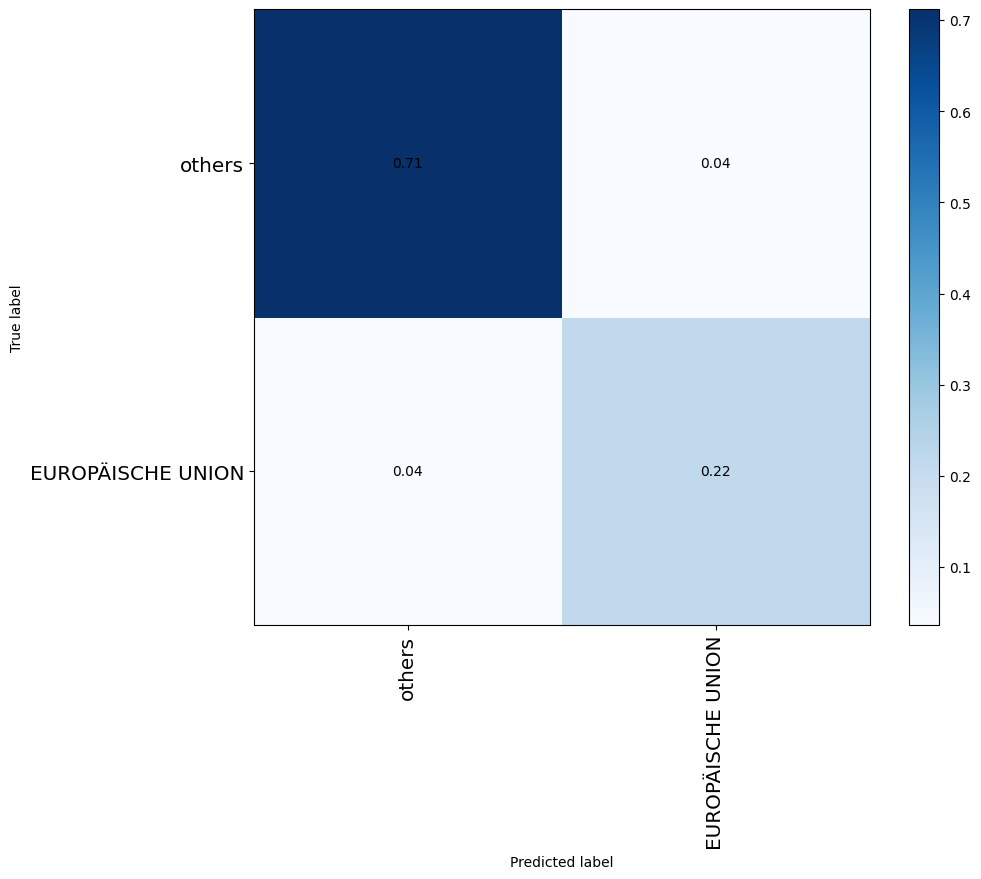

Set Population: 51985
Accuracy: 0.9650


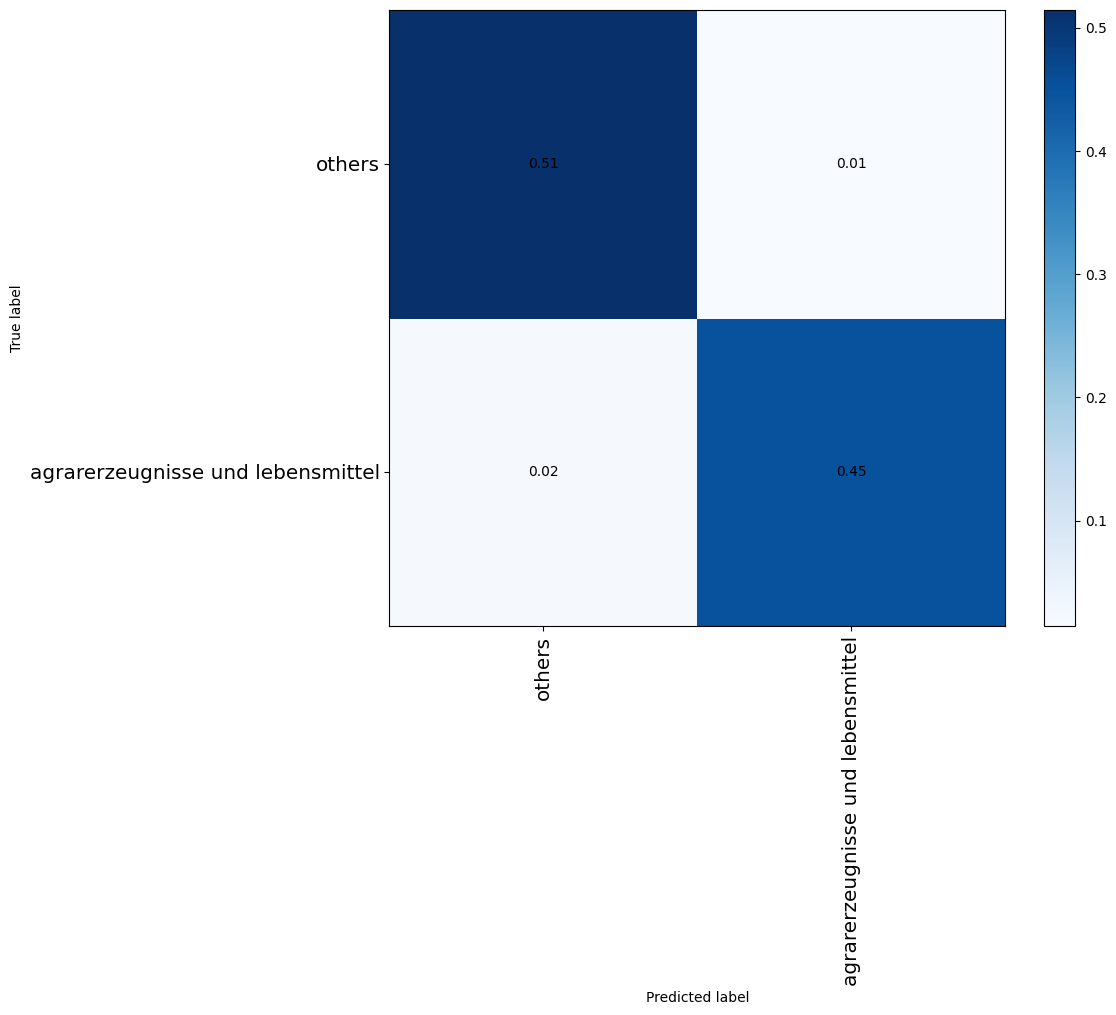

Set Population: 51985
Accuracy: 0.9682


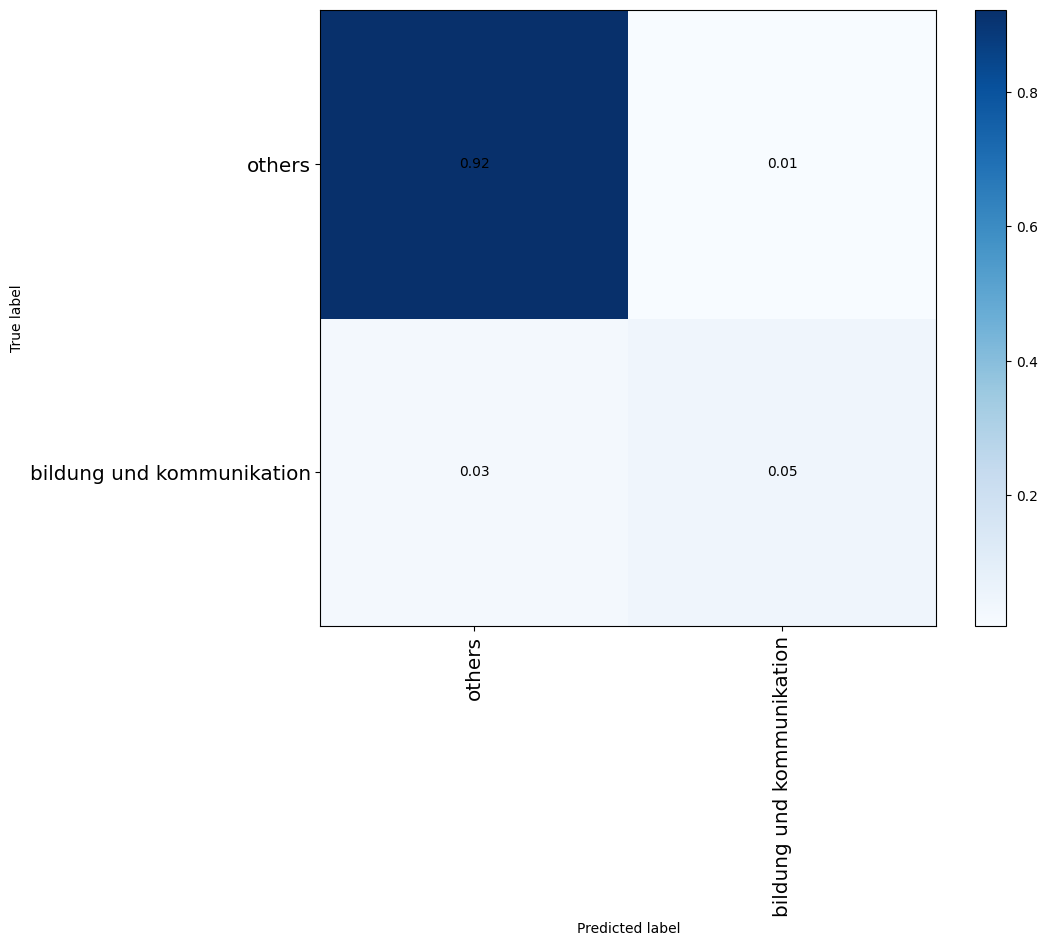

Set Population: 51985
Accuracy: 0.9929


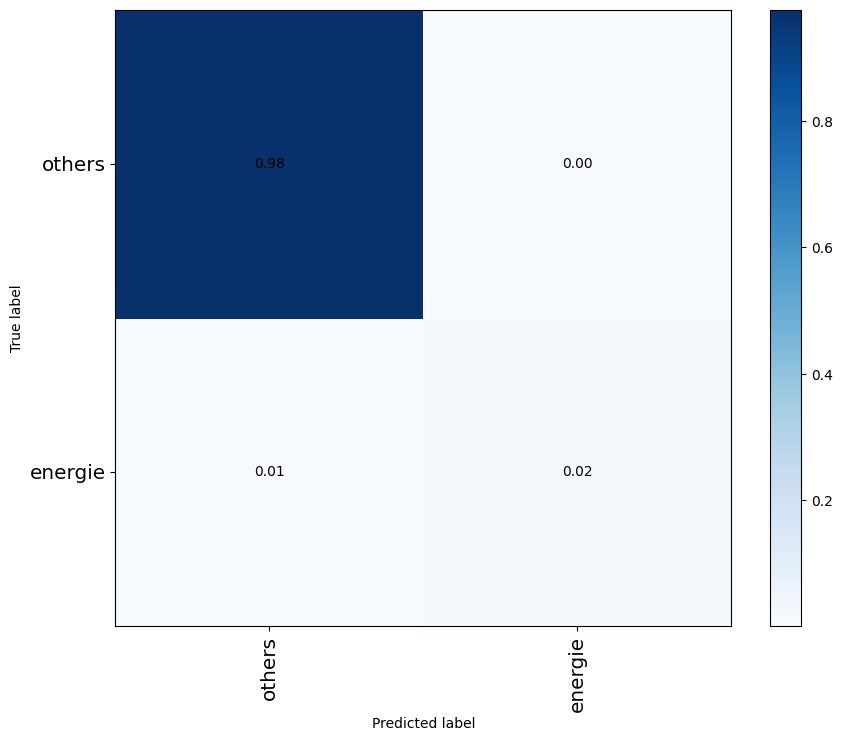

Set Population: 51985
Accuracy: 0.9634


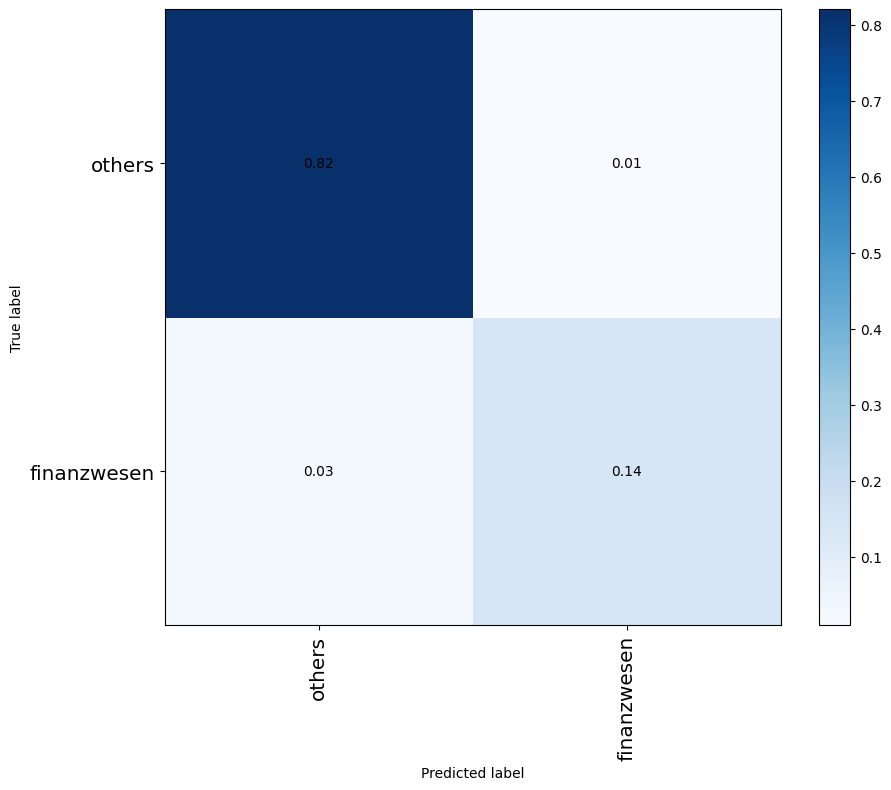

Set Population: 51985
Accuracy: 0.9451


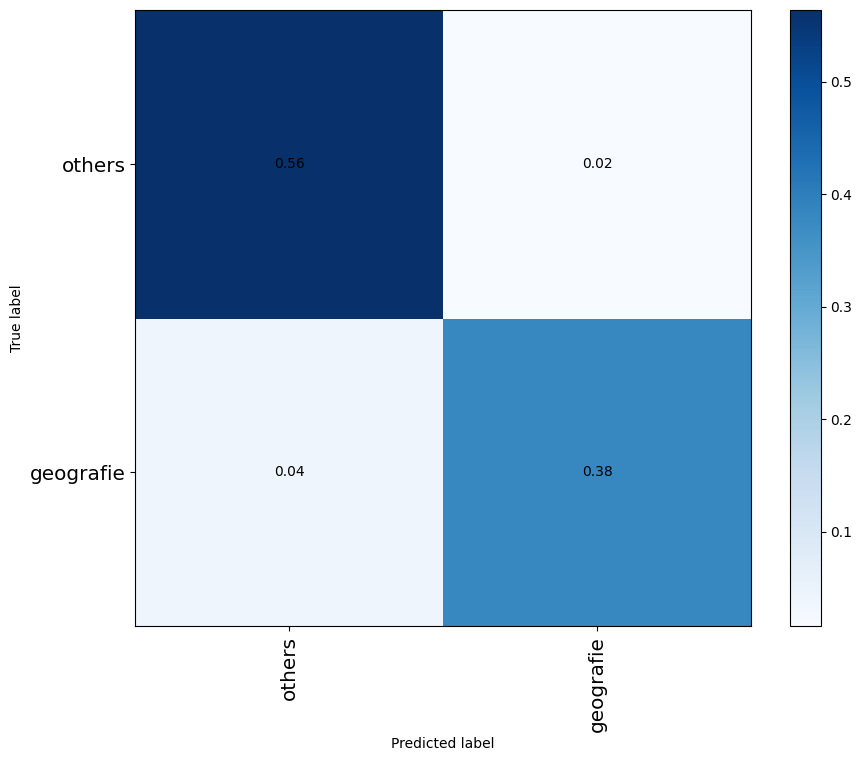

Set Population: 51985
Accuracy: 0.9384


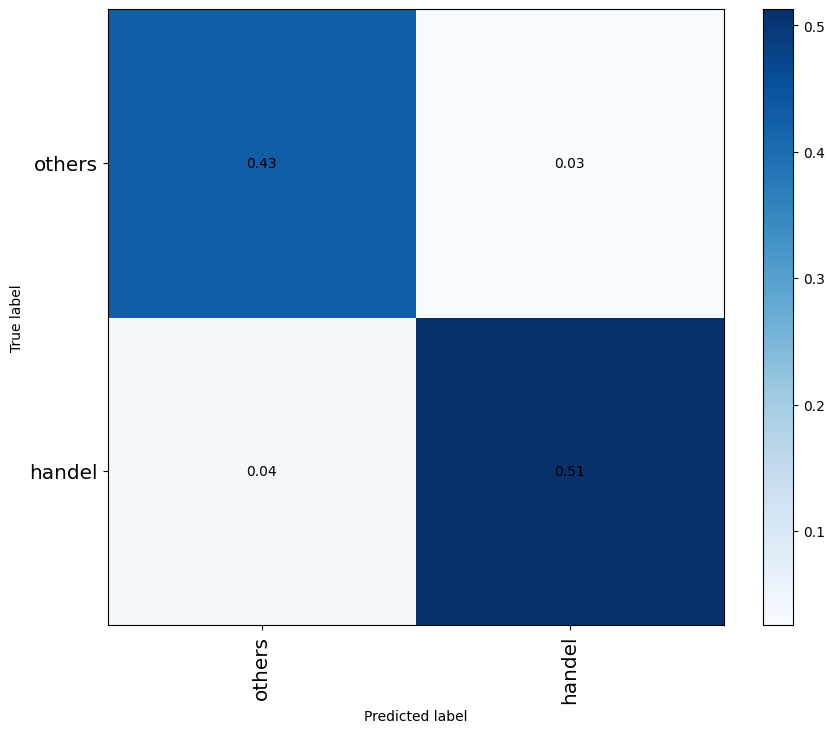

Set Population: 51985
Accuracy: 0.9684


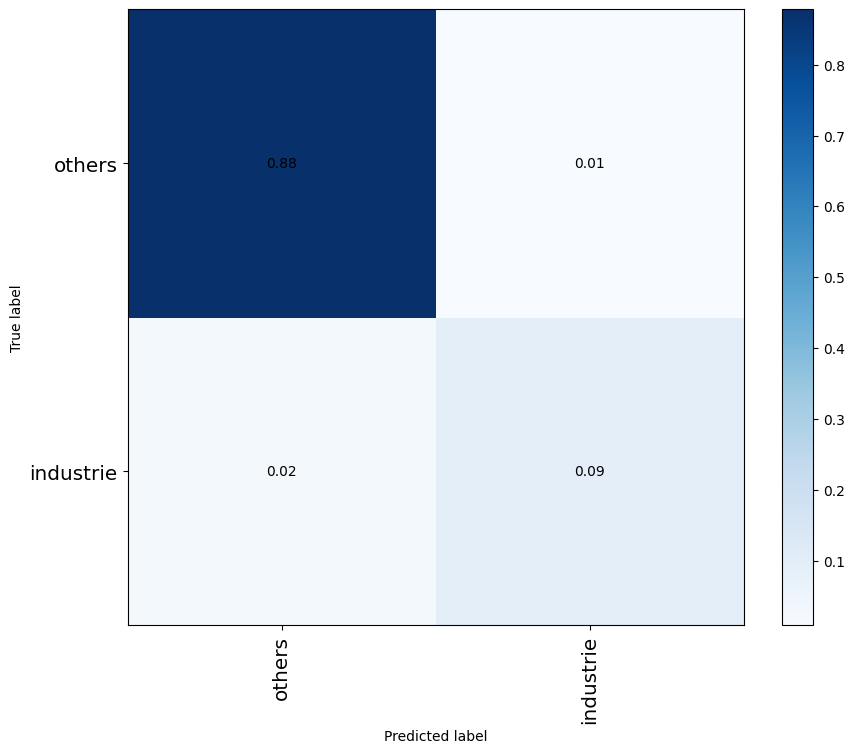

Set Population: 51985
Accuracy: 0.9442


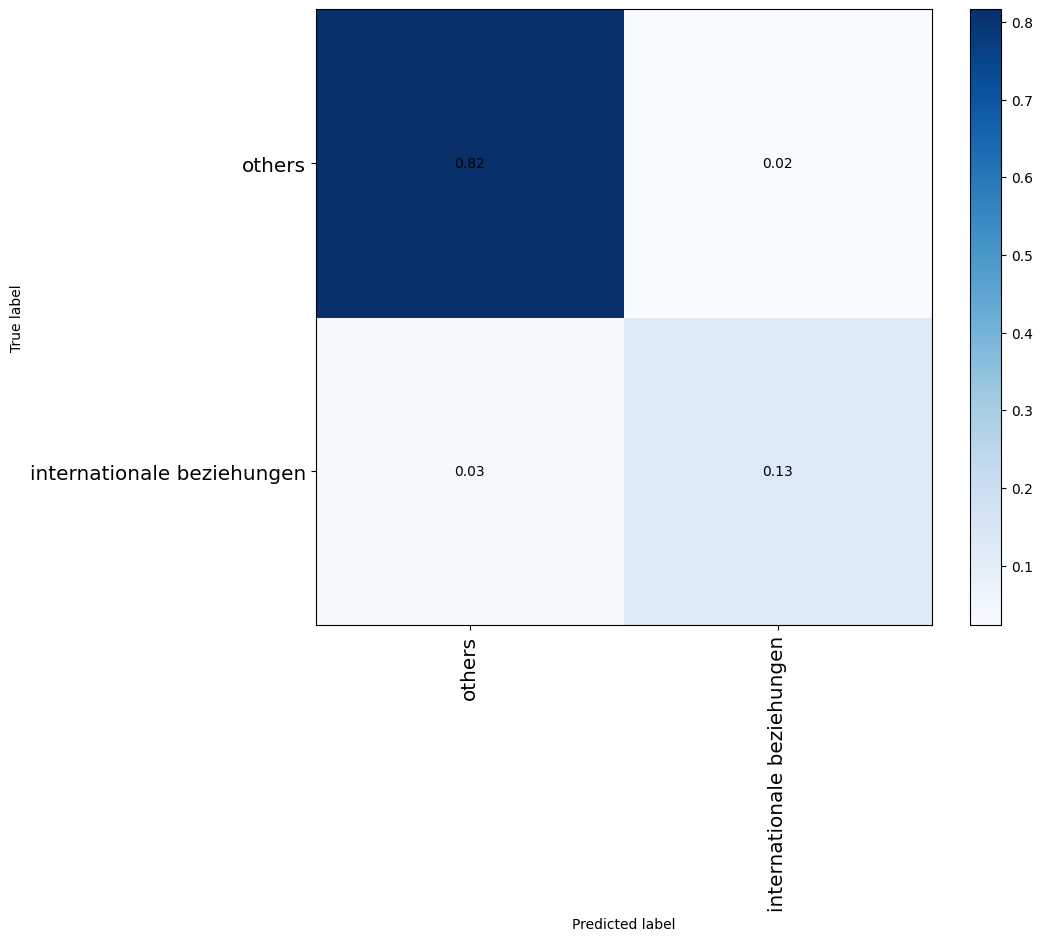

Set Population: 51985
Accuracy: 0.9915


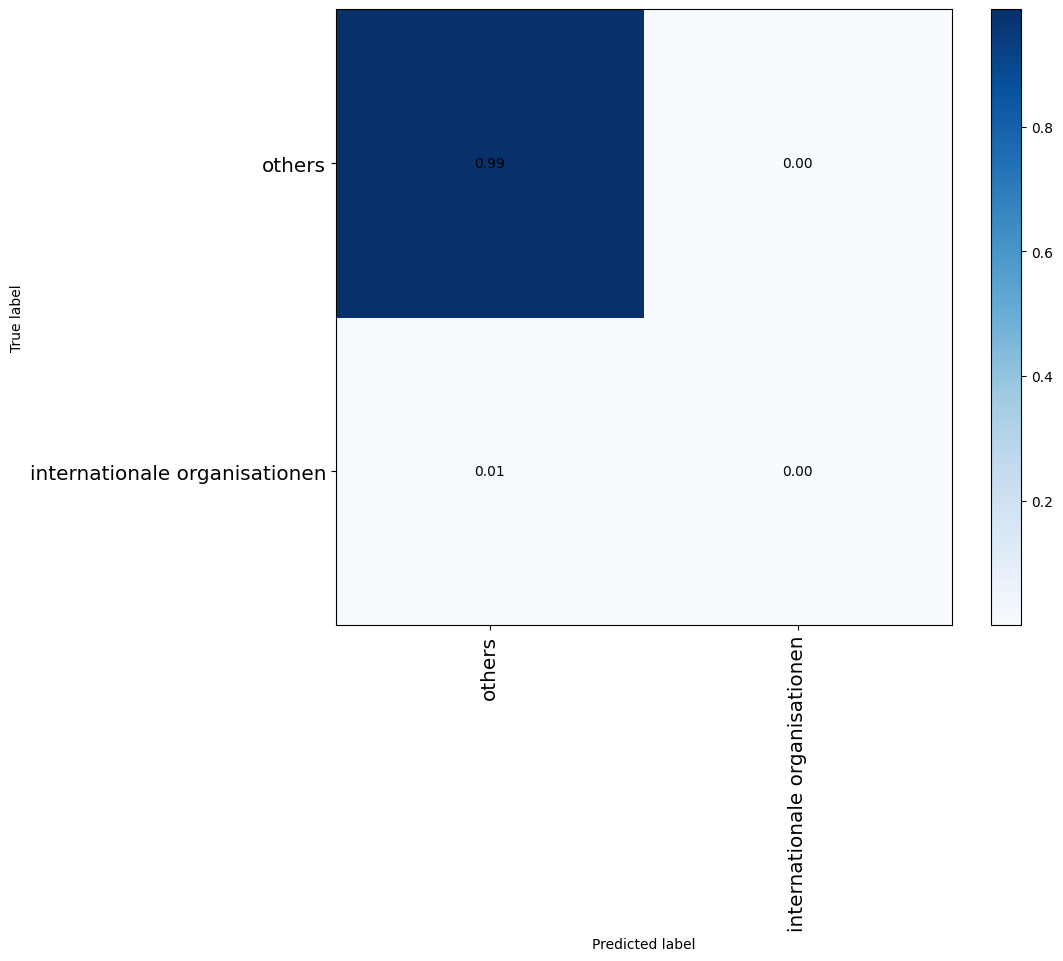

Set Population: 51985
Accuracy: 0.9414


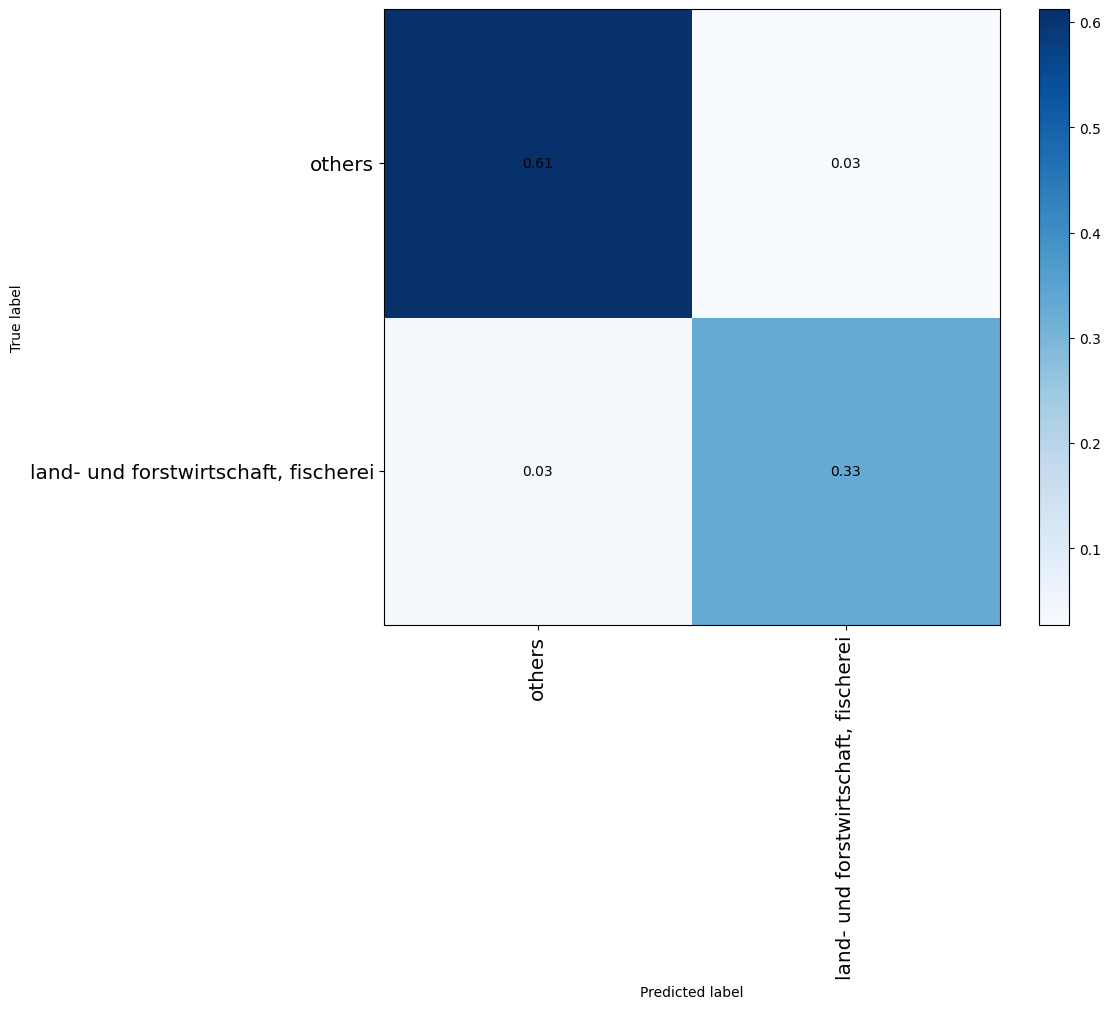

Set Population: 51985
Accuracy: 0.9665


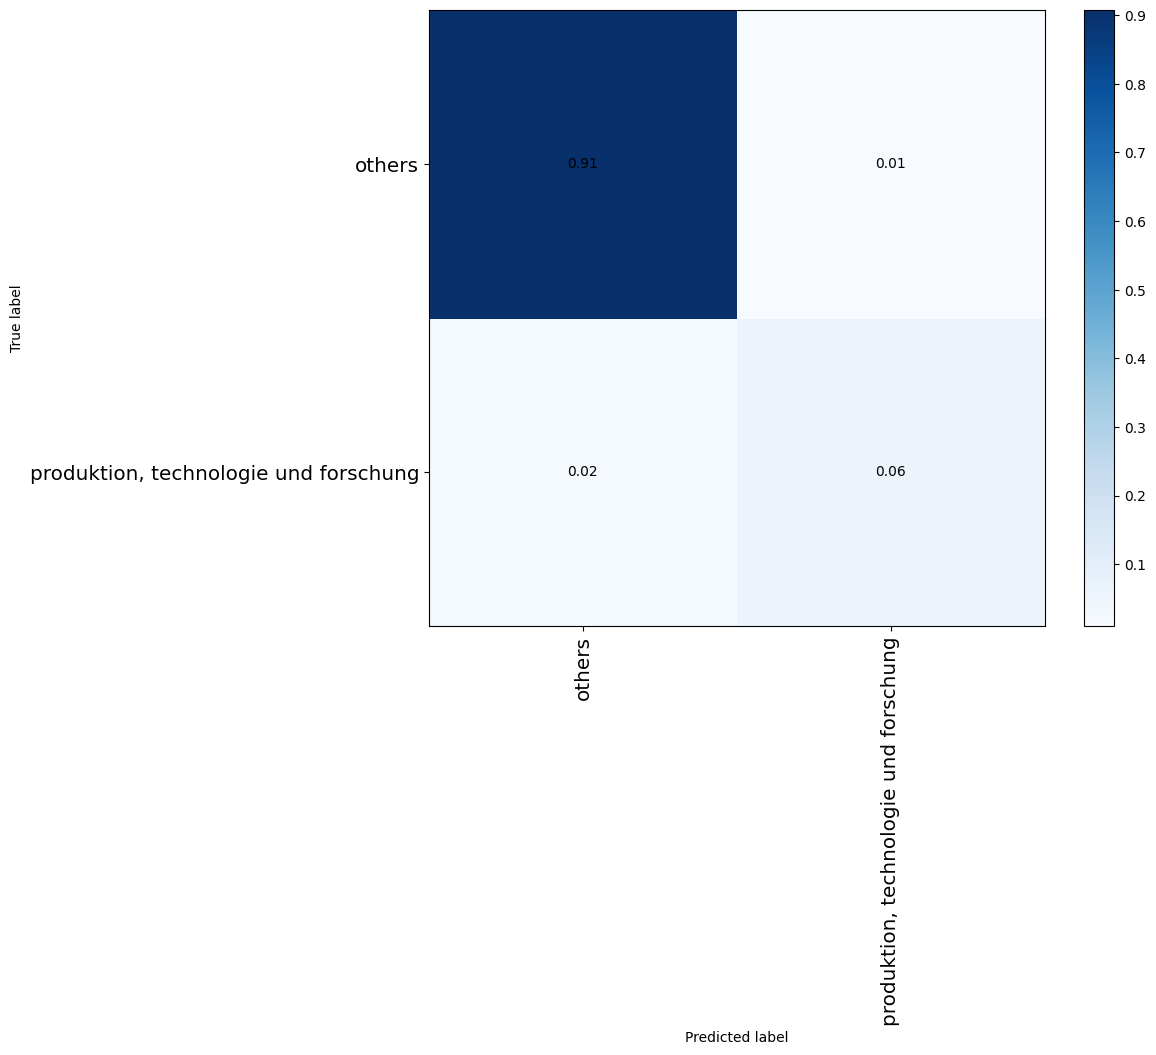

Set Population: 51985
Accuracy: 0.9742


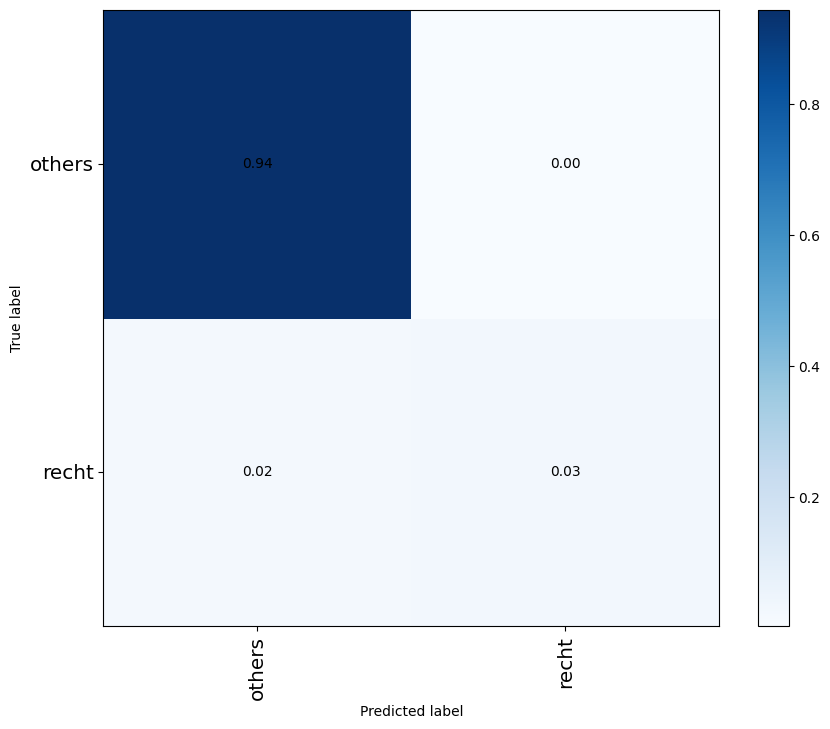

Set Population: 51985
Accuracy: 0.9594


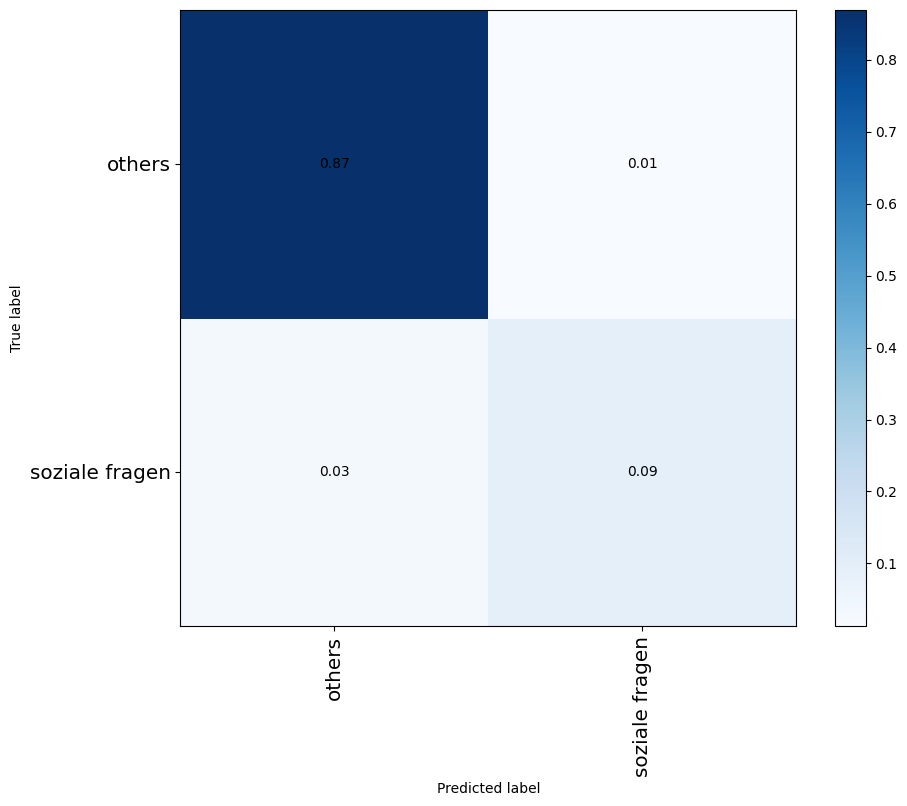

Set Population: 51985
Accuracy: 0.9783


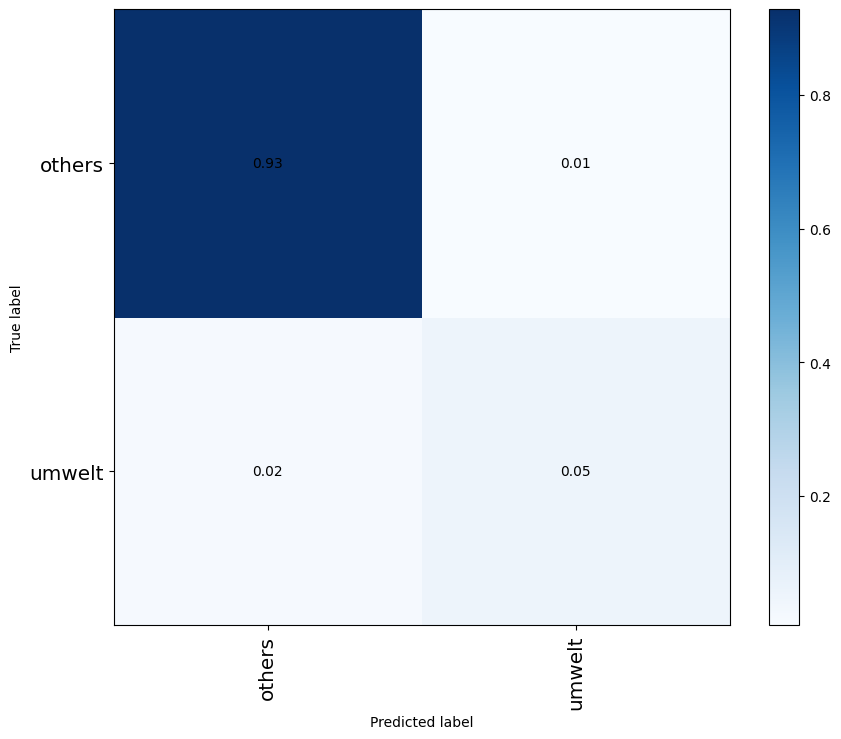

Set Population: 51985
Accuracy: 0.9724


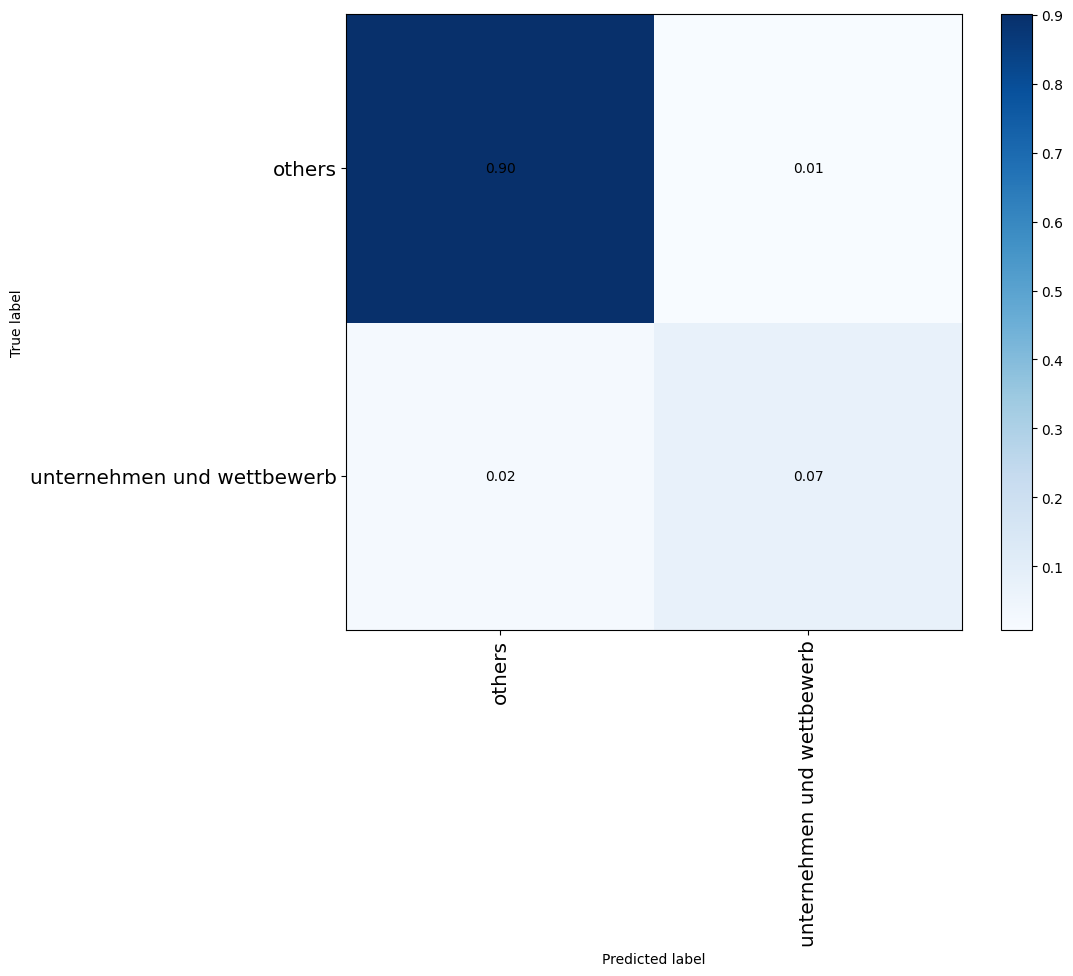

Set Population: 51985
Accuracy: 0.9858


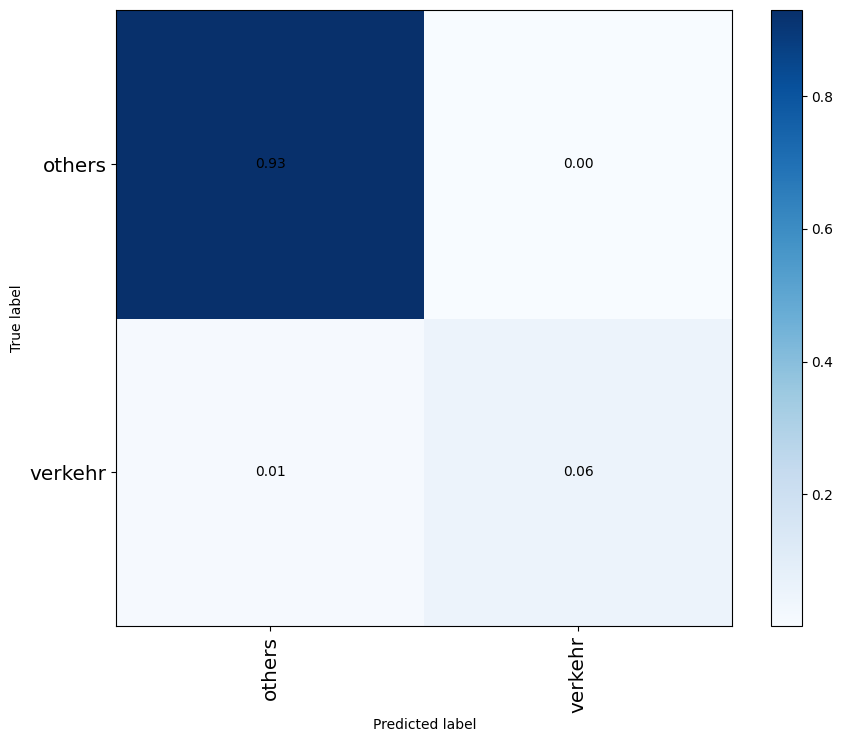

Set Population: 51985
Accuracy: 0.9544


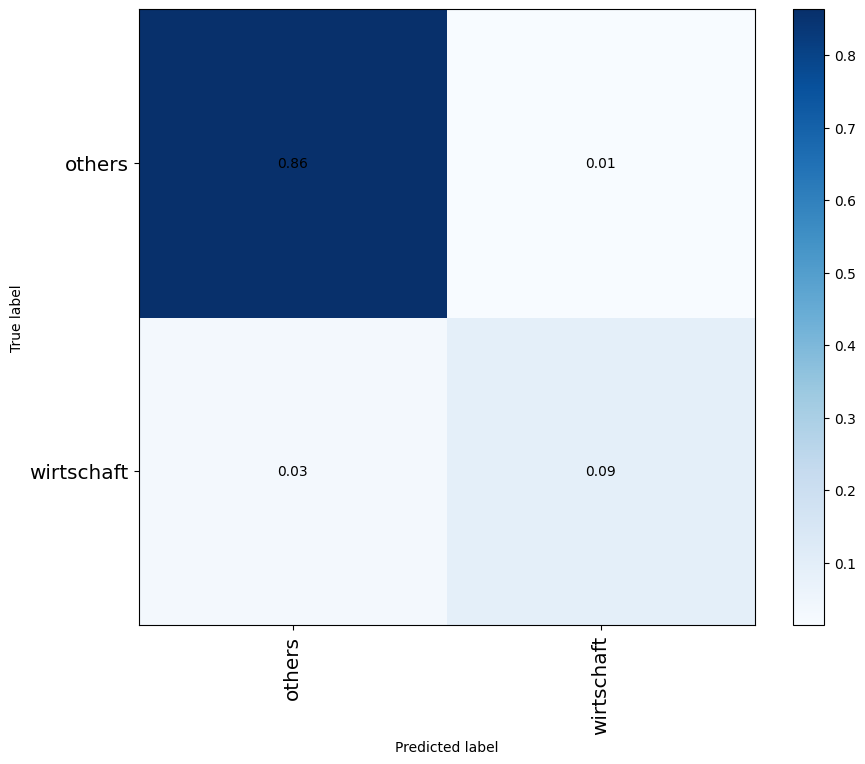

Set Population: 51985
Accuracy: 0.9904


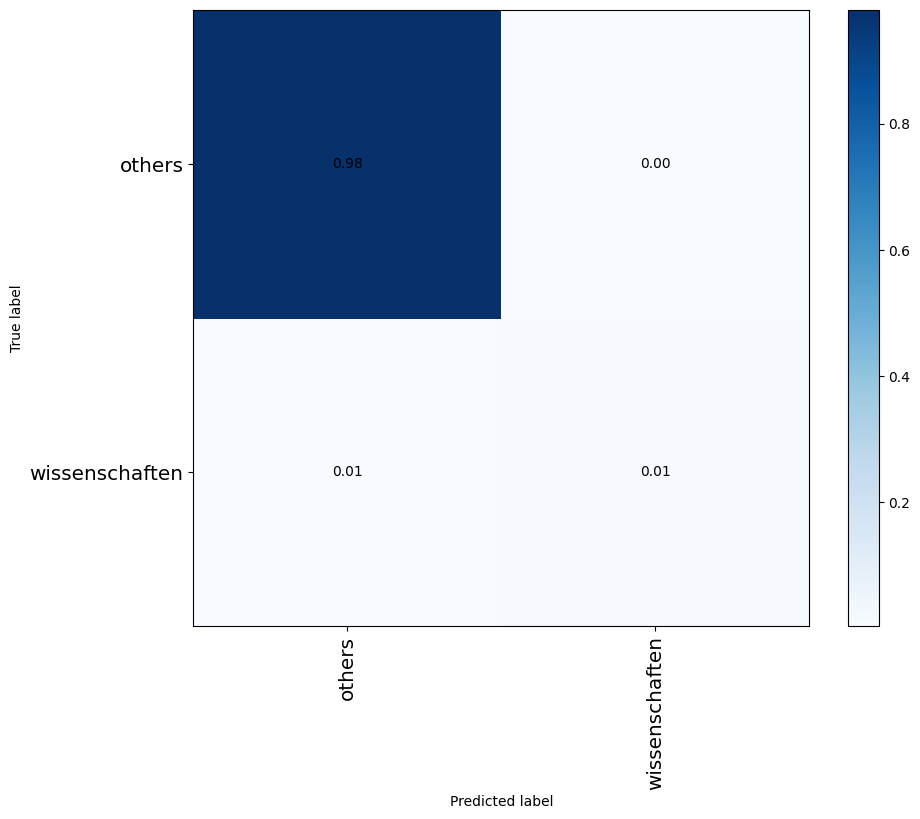

                                       precision    recall  f1-score   support

                    EUROPÄISCHE UNION       0.86      0.85      0.86     13092
    agrarerzeugnisse und lebensmittel       0.97      0.96      0.96     24468
            bildung und kommunikation       0.88      0.64      0.74      3697
                              energie       0.94      0.73      0.82      1169
                          finanzwesen       0.93      0.84      0.89      8791
                            geografie       0.96      0.91      0.93     21812
                               handel       0.95      0.93      0.94     28544
                            industrie       0.91      0.80      0.85      5897
           internationale beziehungen       0.85      0.80      0.82      8379
        internationale organisationen       0.81      0.29      0.43       570
 land- und forstwirtschaft, fischerei       0.92      0.91      0.92     18762
produktion, technologie und forschung       0.86   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
# see https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea for interpretation

from fhnw.nlp.utils.ploting import report_classification_results

report_classification_results(params, labels_train + labels_val, labels_train_pred + labels_val_pred)

Set Population: 13008
Accuracy: 0.8895


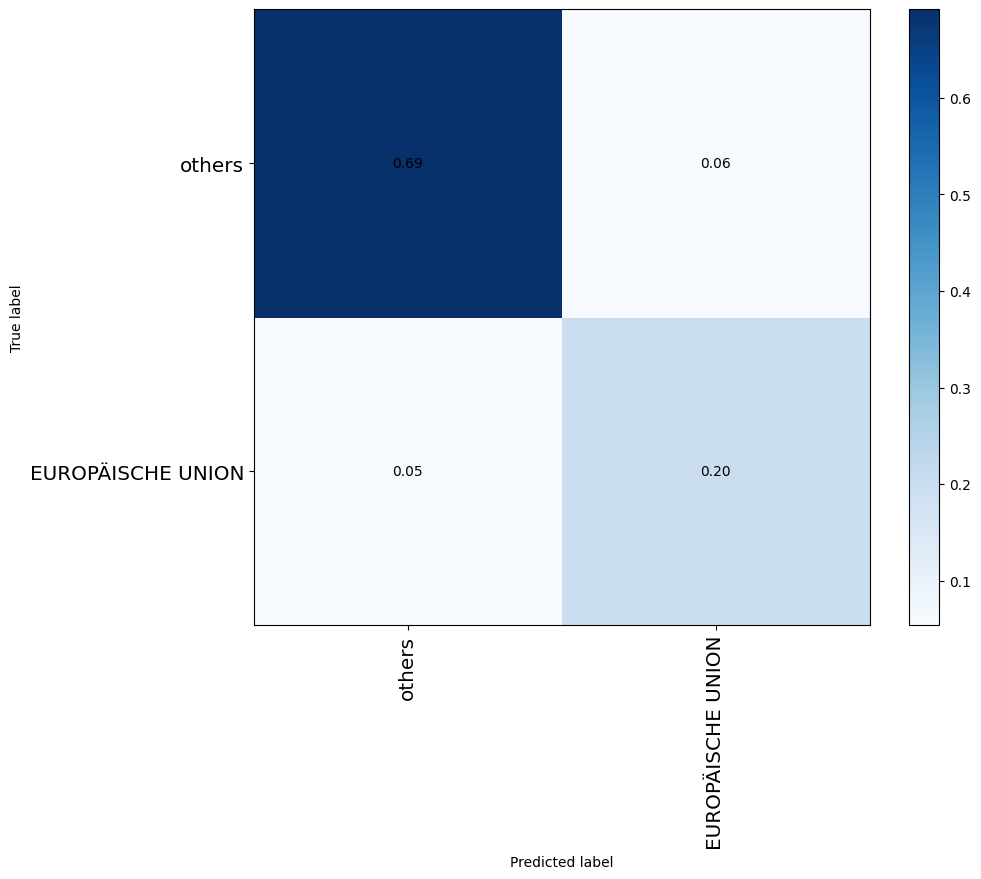

Set Population: 13008
Accuracy: 0.9485


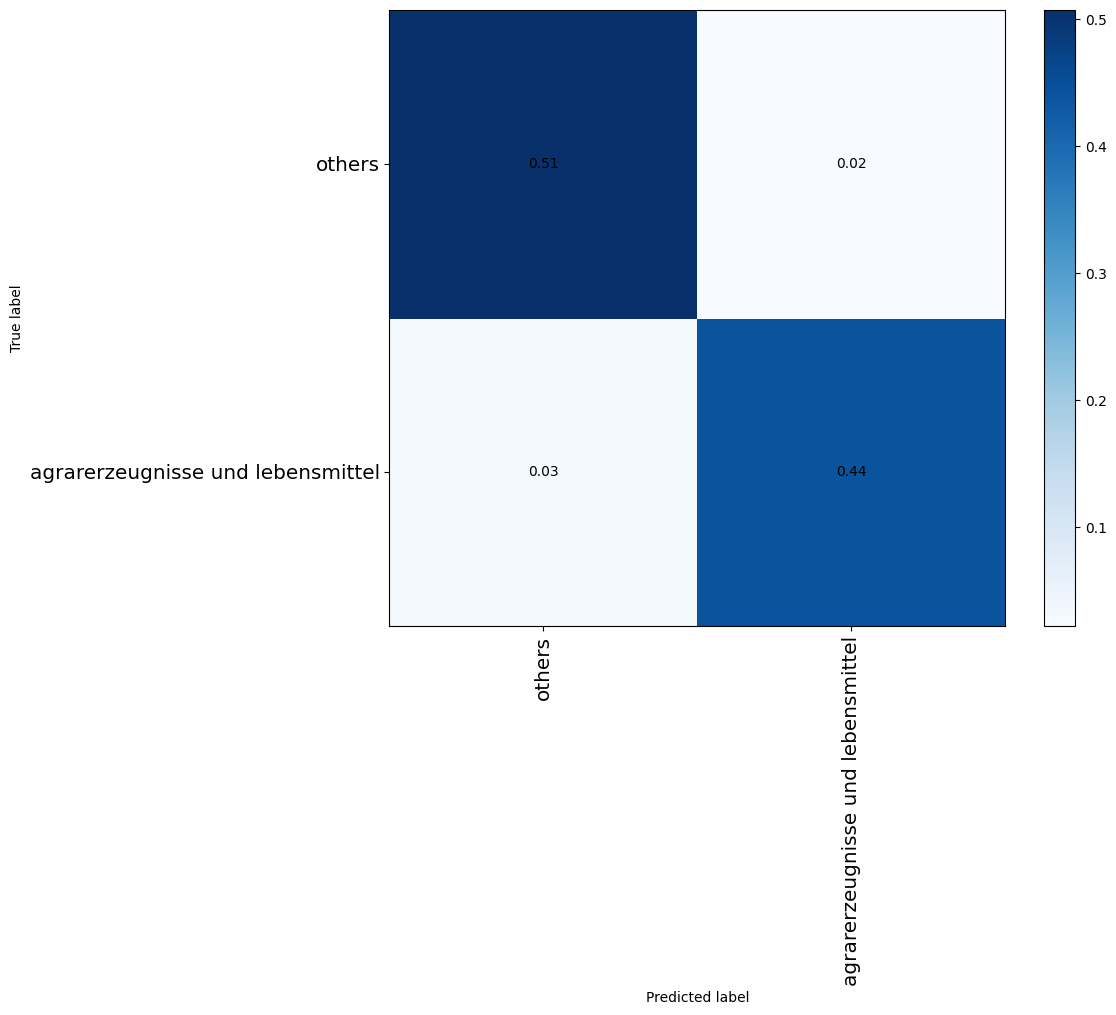

Set Population: 13008
Accuracy: 0.9557


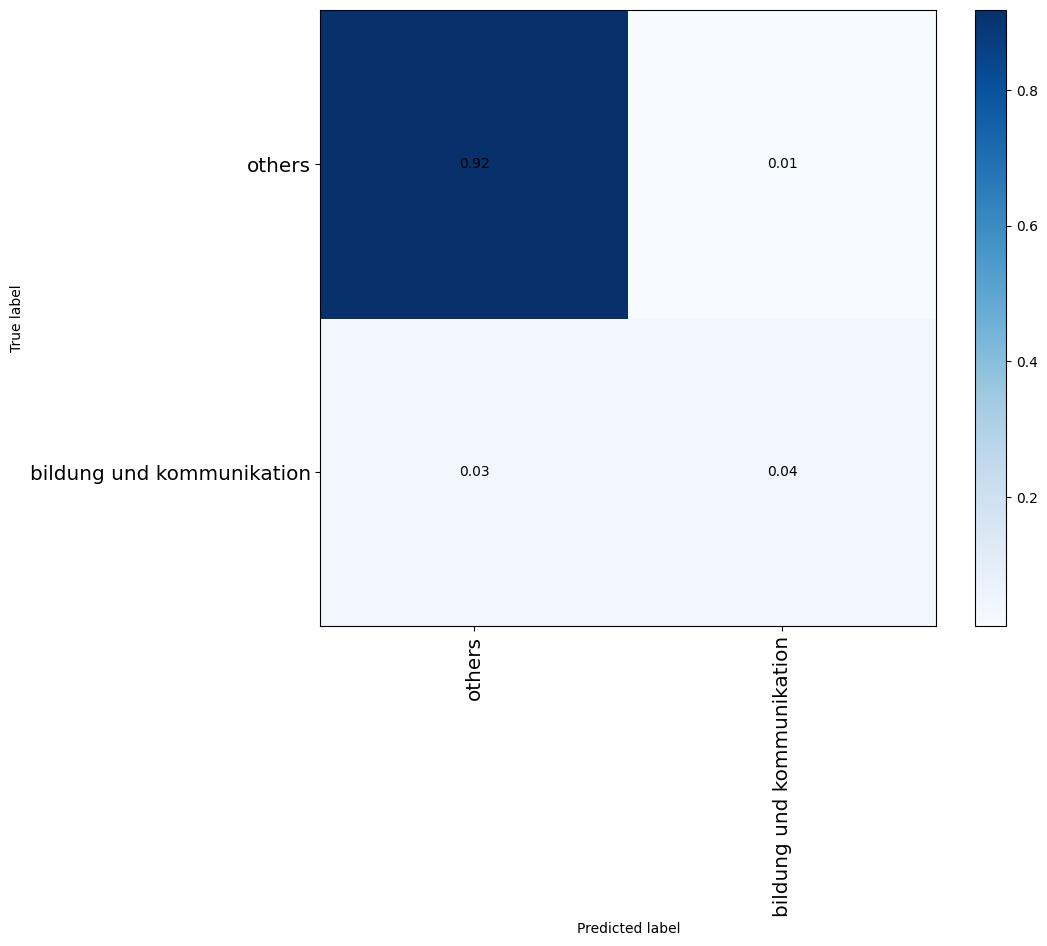

Set Population: 13008
Accuracy: 0.9910


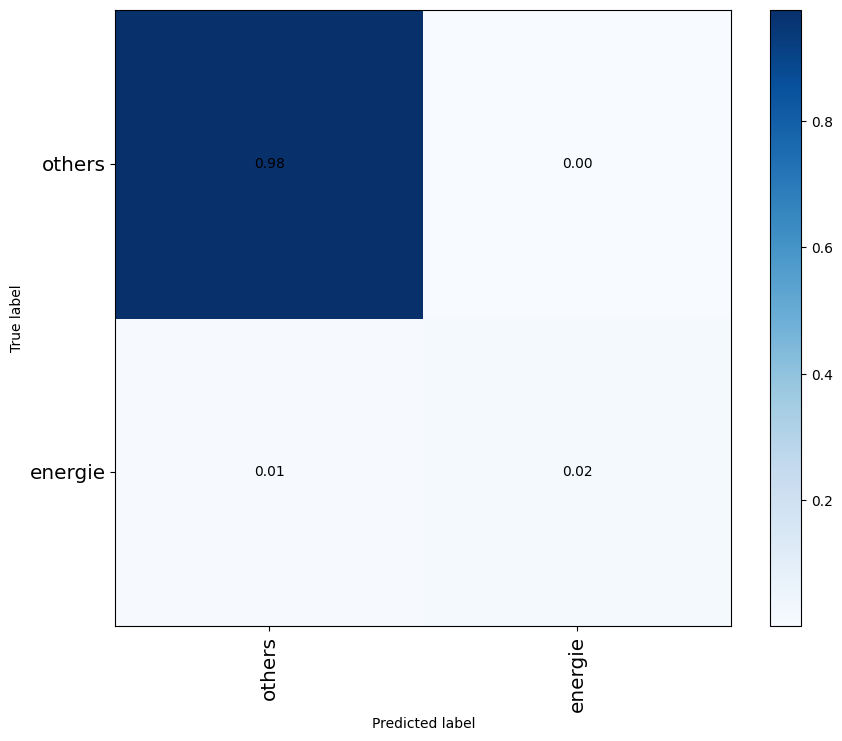

Set Population: 13008
Accuracy: 0.9513


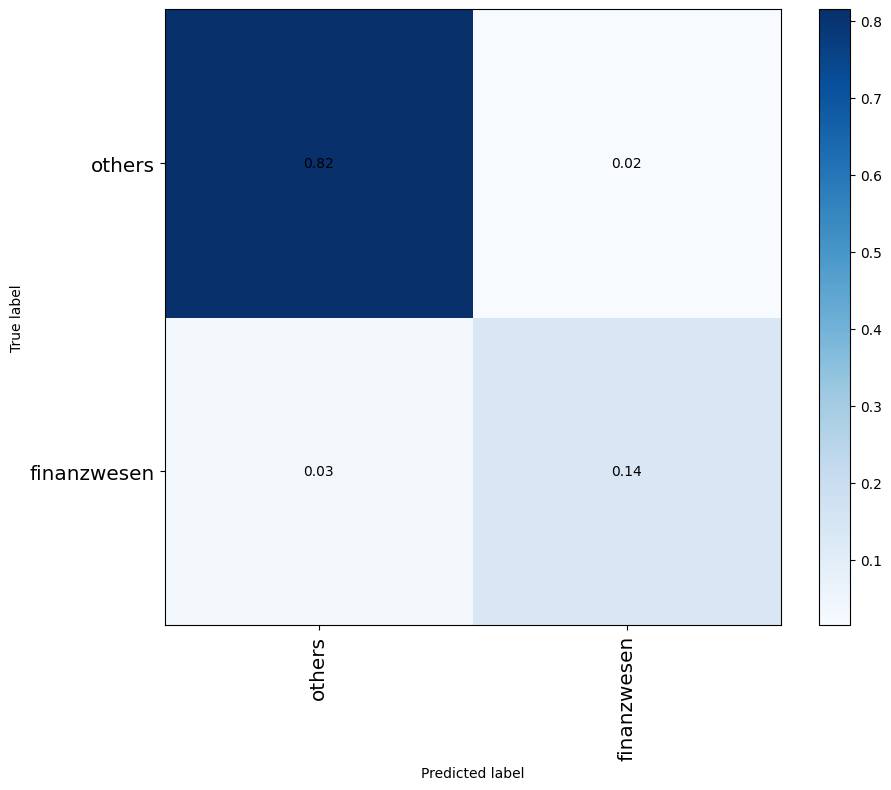

Set Population: 13008
Accuracy: 0.9240


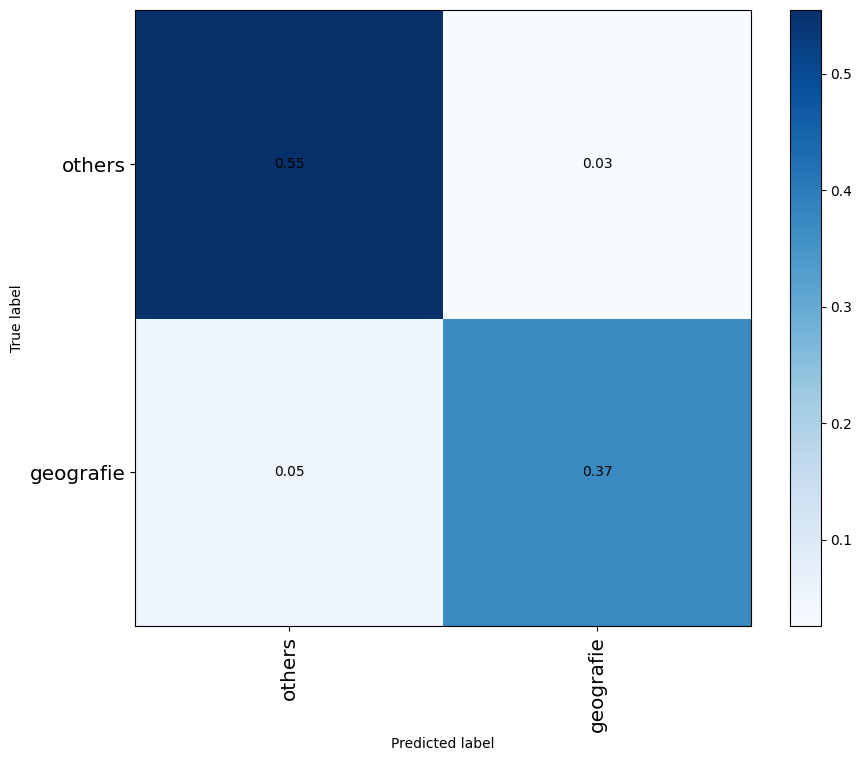

Set Population: 13008
Accuracy: 0.9116


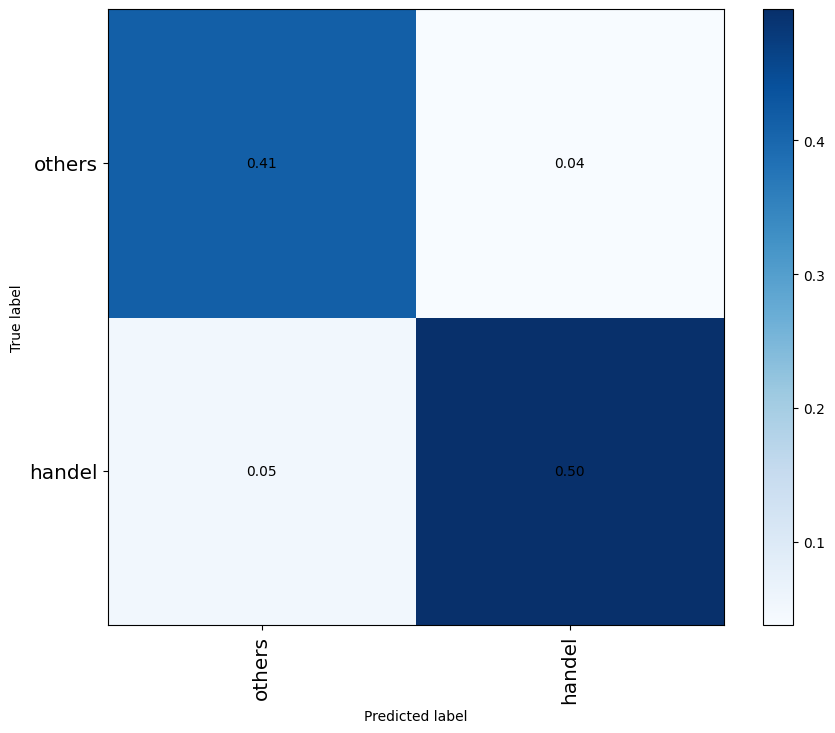

Set Population: 13008
Accuracy: 0.9558


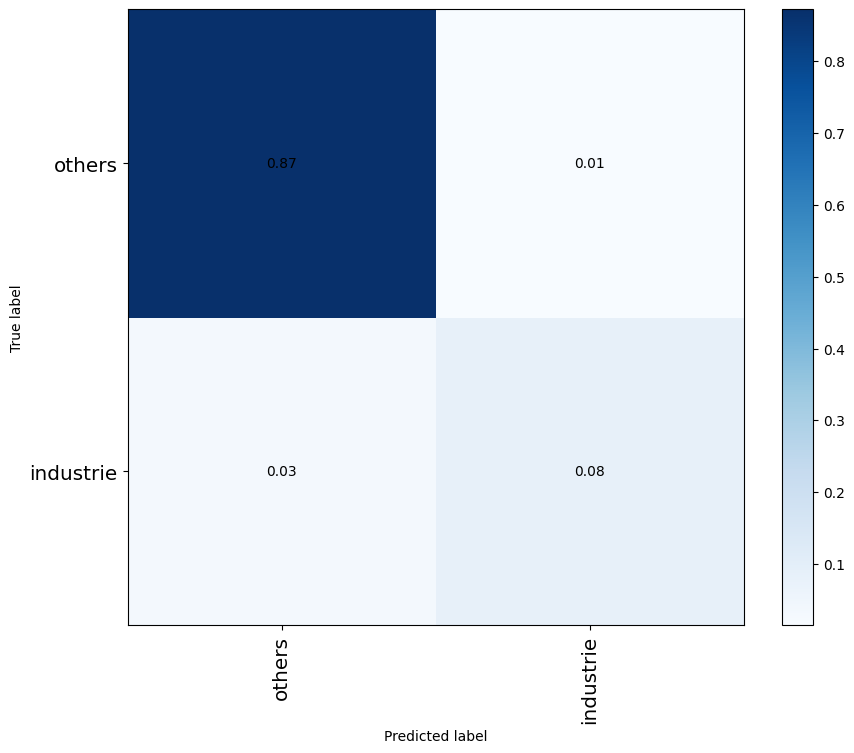

Set Population: 13008
Accuracy: 0.9239


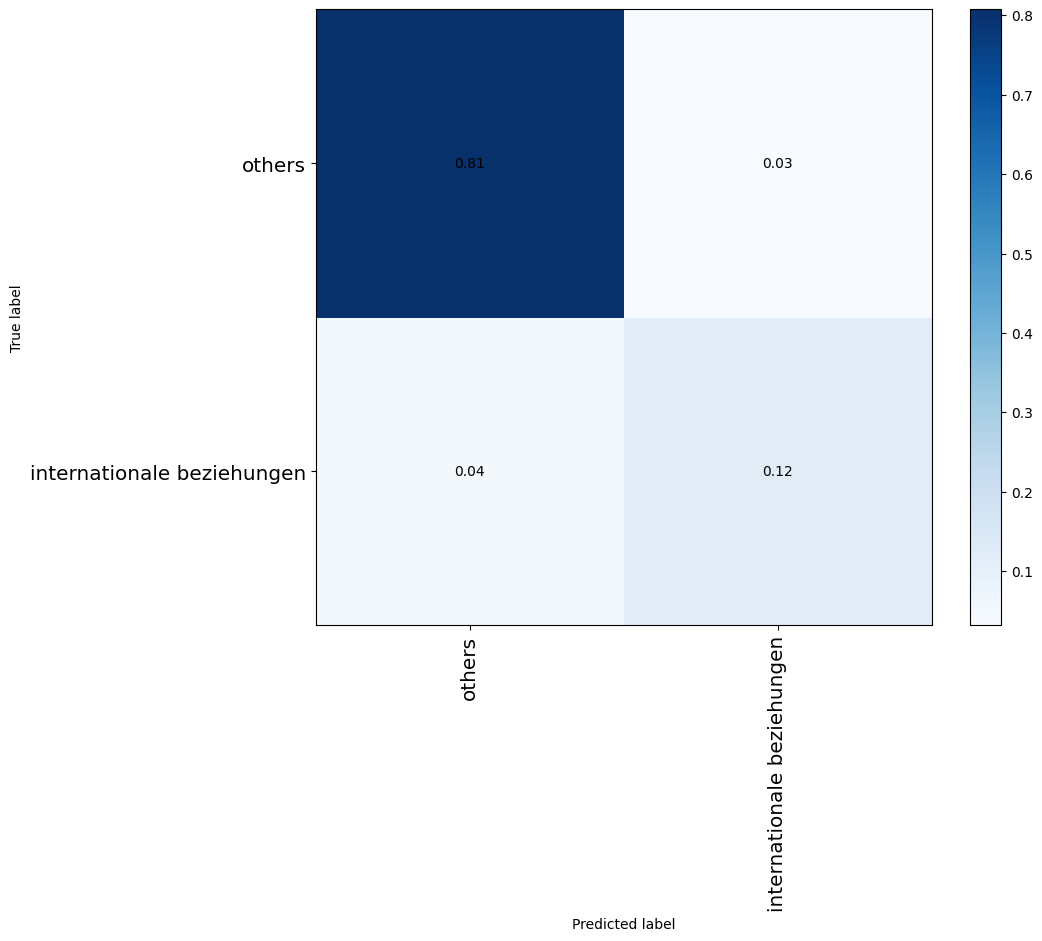

Set Population: 13008
Accuracy: 0.9905


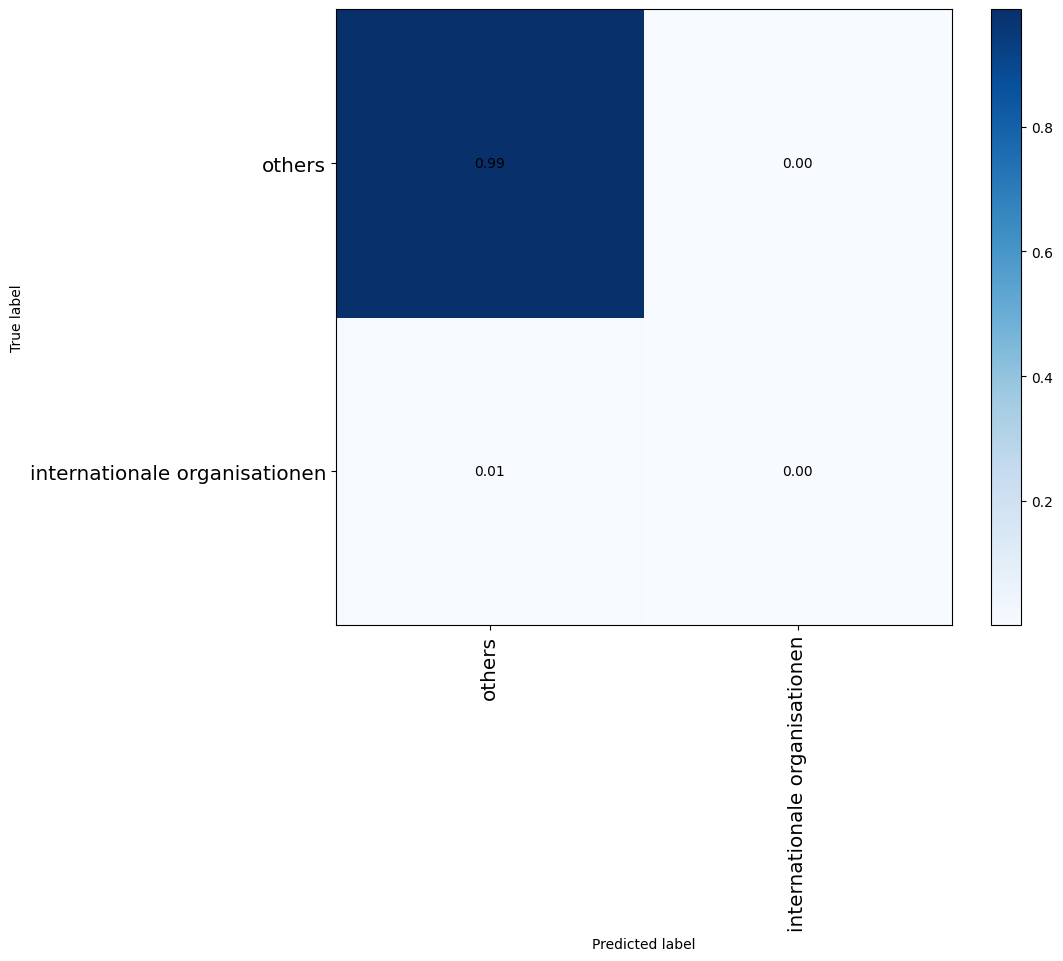

Set Population: 13008
Accuracy: 0.9241


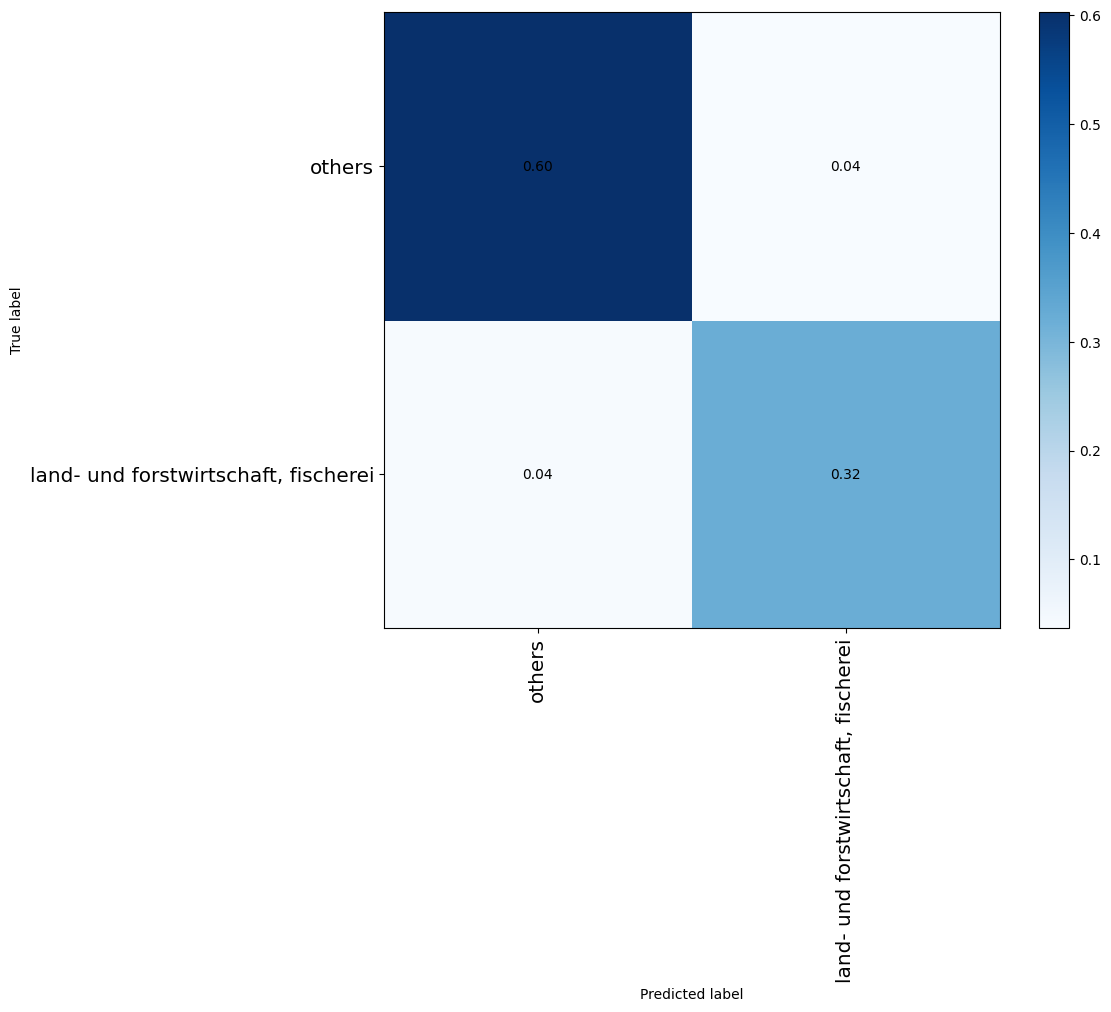

Set Population: 13008
Accuracy: 0.9492


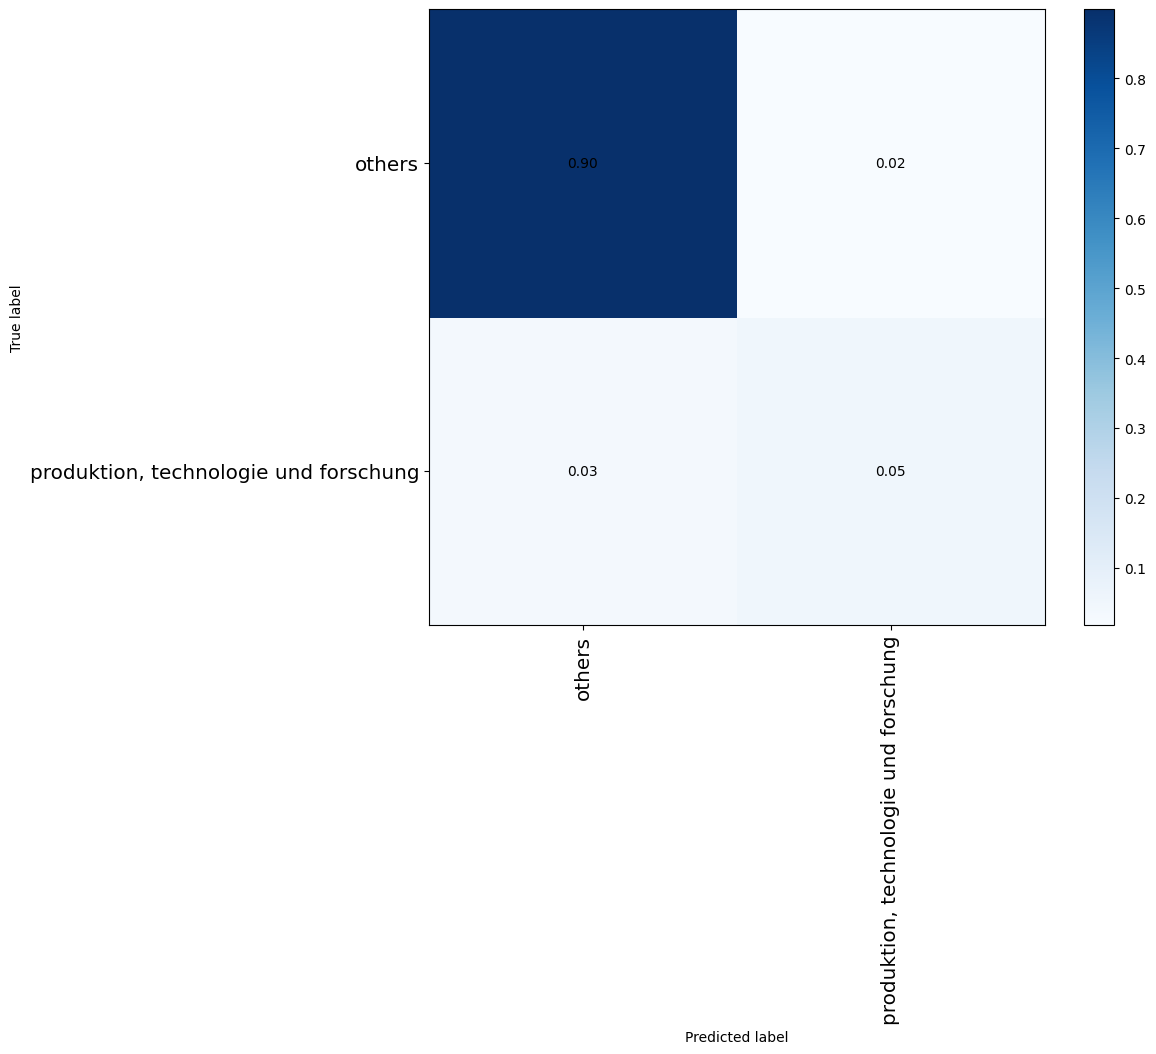

Set Population: 13008
Accuracy: 0.9660


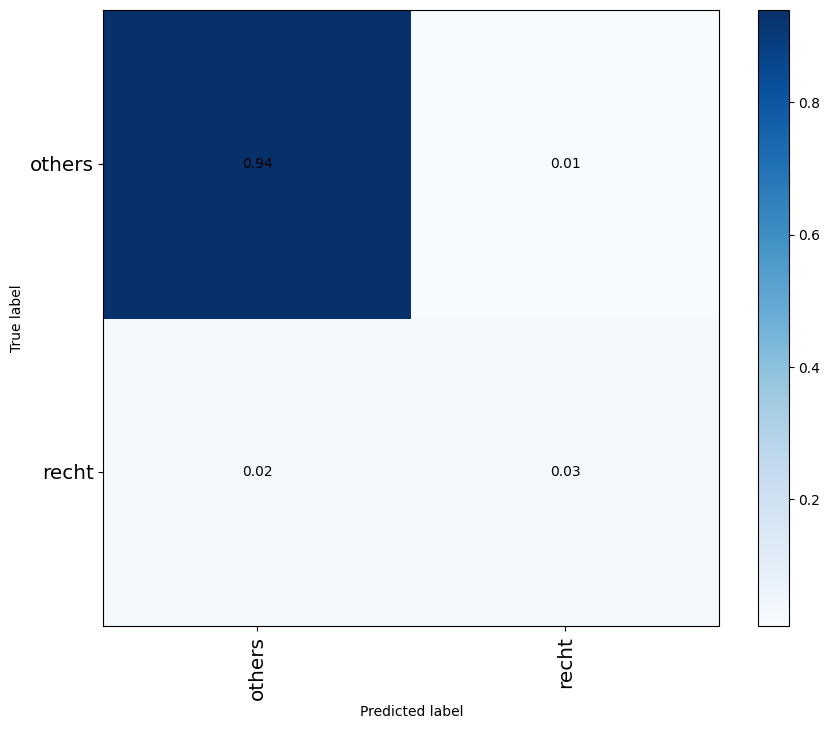

Set Population: 13008
Accuracy: 0.9443


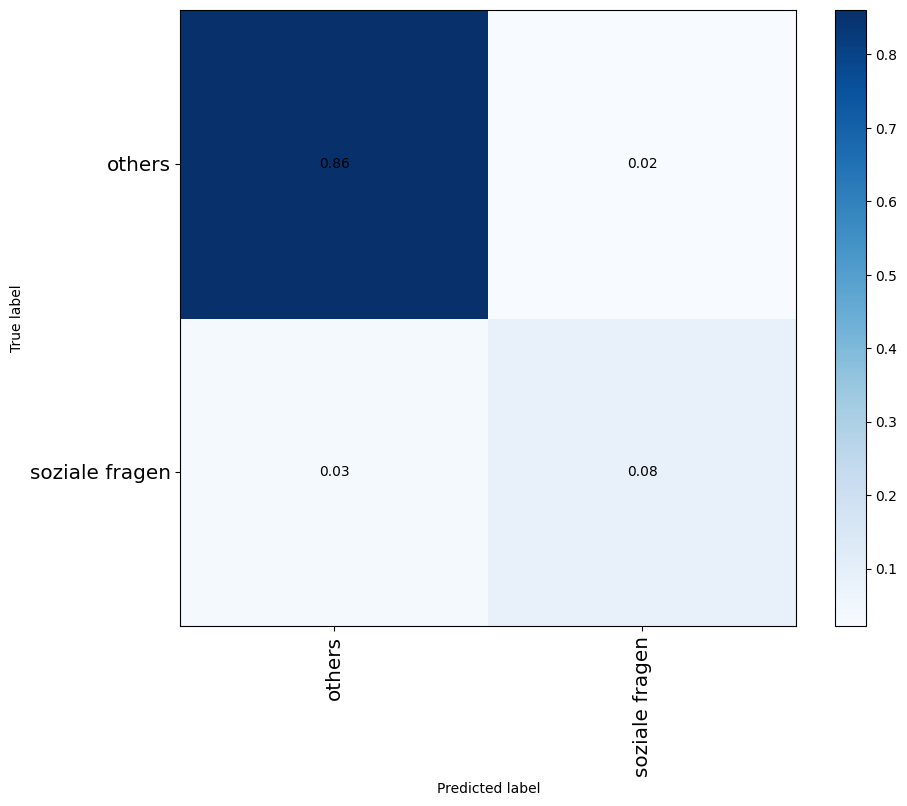

Set Population: 13008
Accuracy: 0.9692


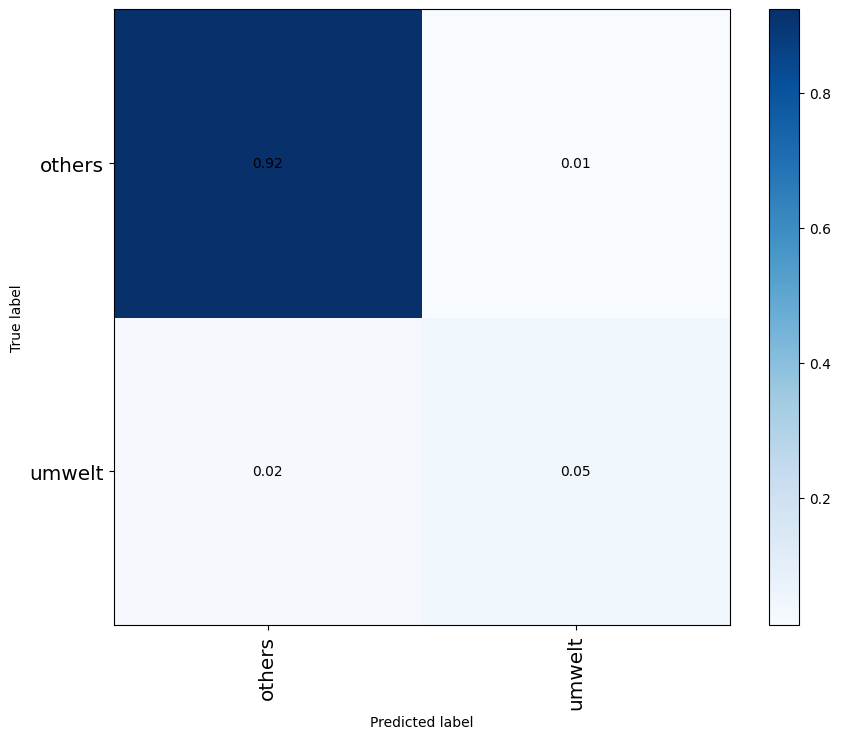

Set Population: 13008
Accuracy: 0.9621


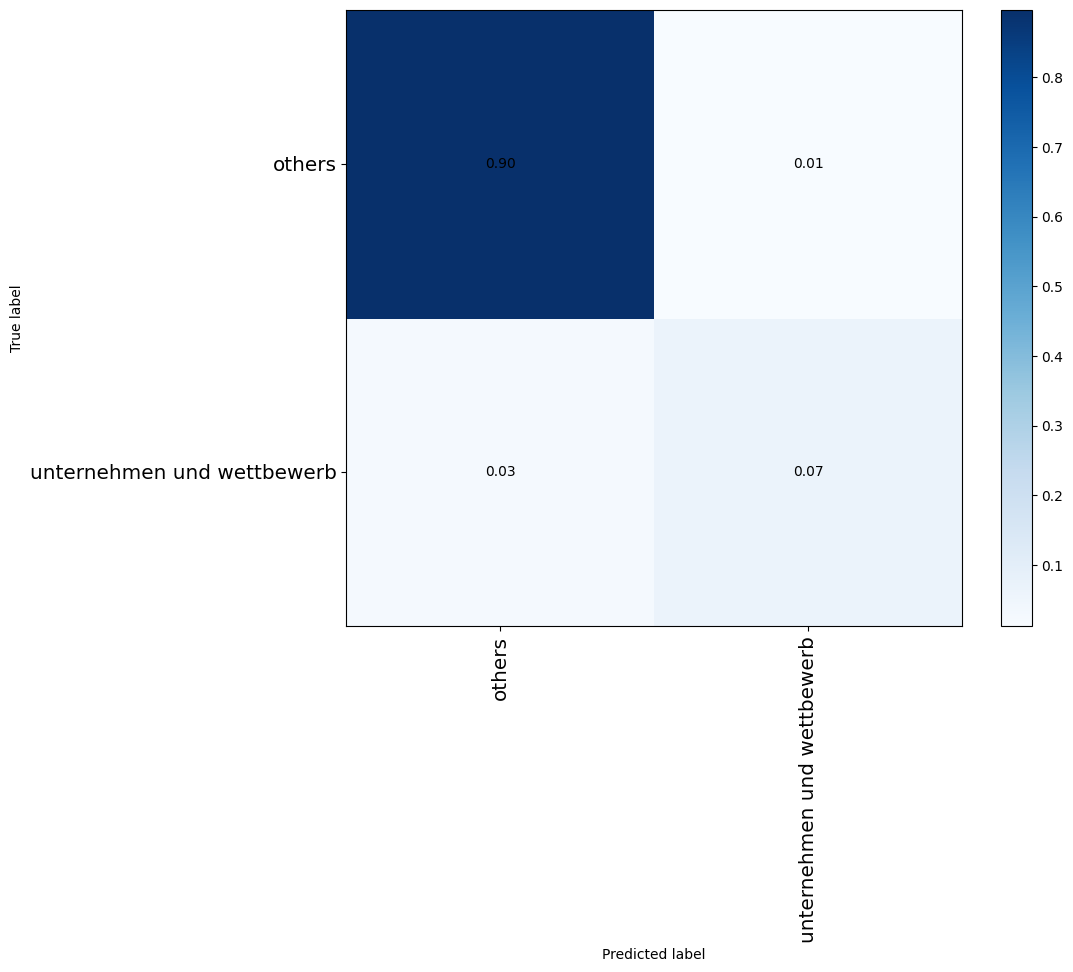

Set Population: 13008
Accuracy: 0.9820


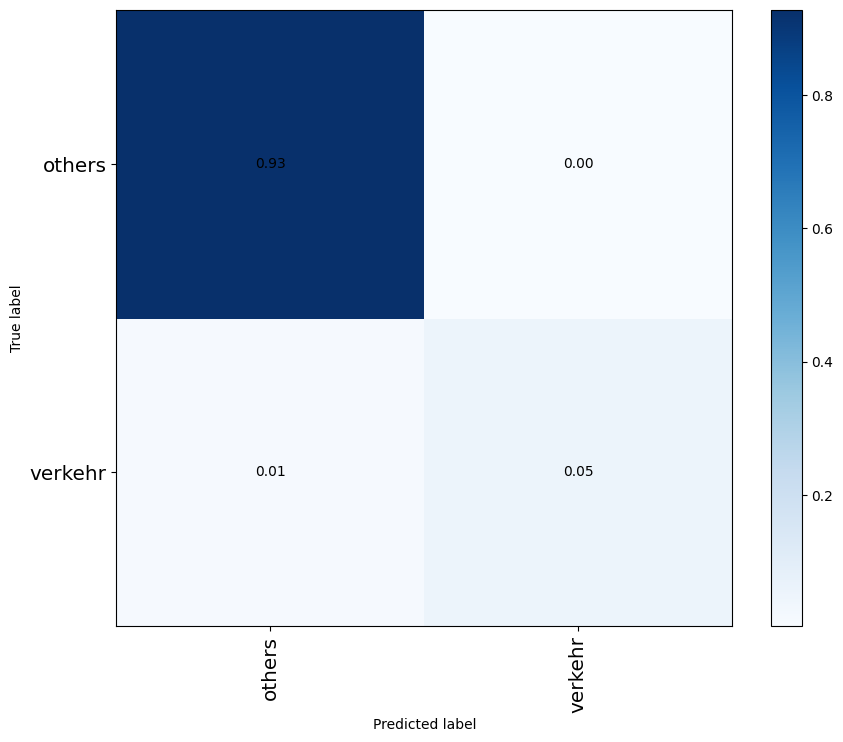

Set Population: 13008
Accuracy: 0.9415


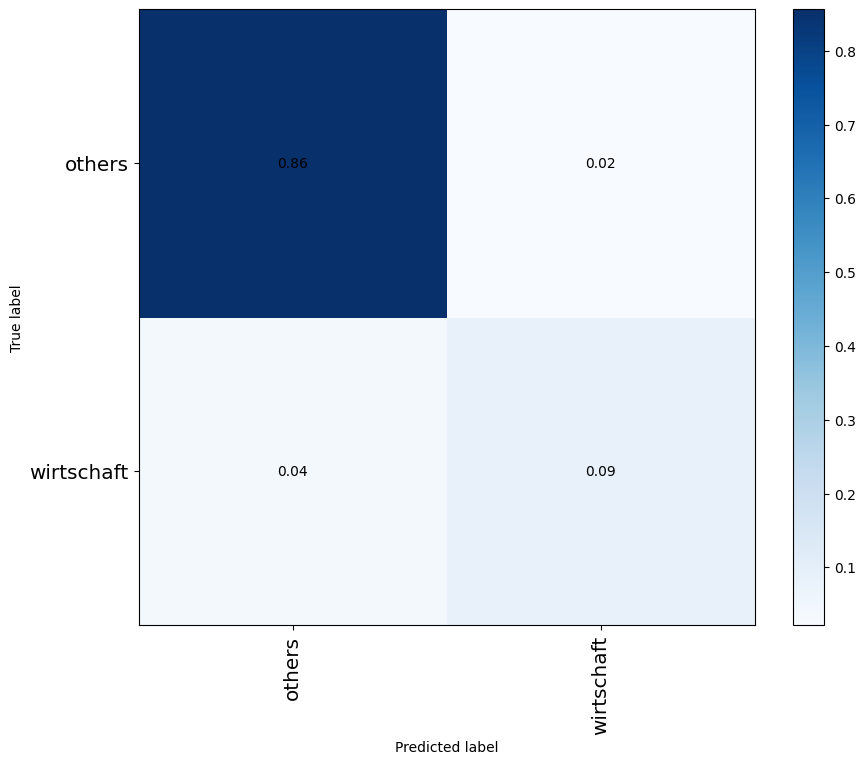

Set Population: 13008
Accuracy: 0.9882


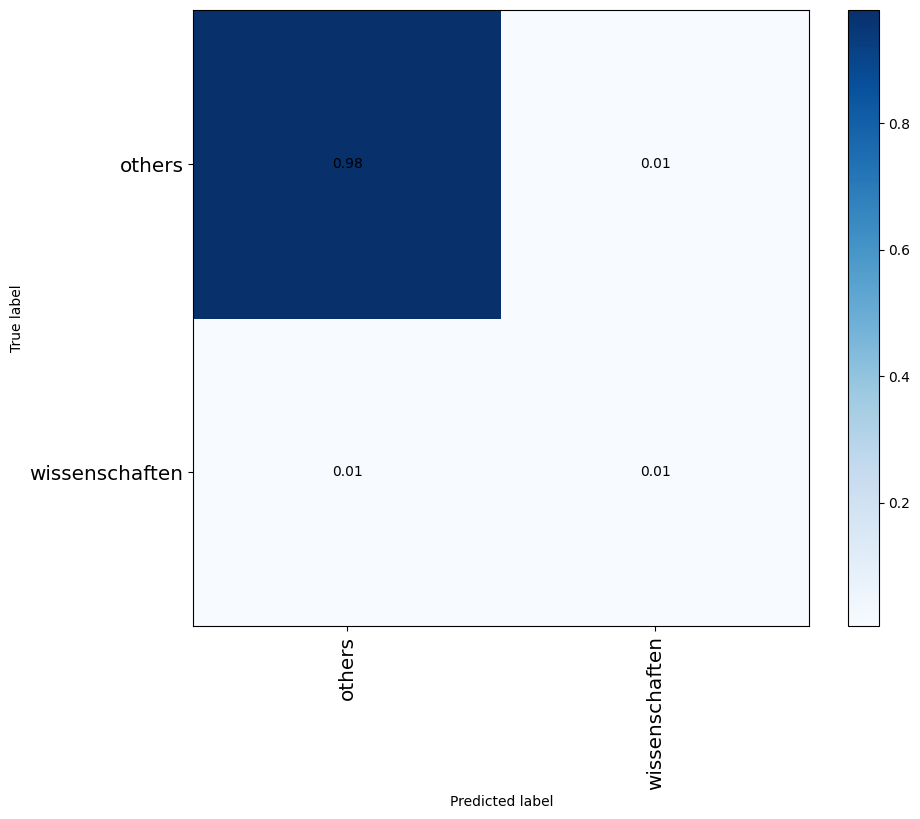

                                       precision    recall  f1-score   support

                    EUROPÄISCHE UNION       0.78      0.79      0.78      3273
    agrarerzeugnisse und lebensmittel       0.95      0.94      0.94      6117
            bildung und kommunikation       0.77      0.53      0.63       925
                              energie       0.89      0.69      0.77       292
                          finanzwesen       0.90      0.80      0.85      2197
                            geografie       0.93      0.88      0.91      5453
                               handel       0.93      0.91      0.92      7137
                            industrie       0.85      0.74      0.79      1474
           internationale beziehungen       0.79      0.72      0.75      2095
        internationale organisationen       0.70      0.23      0.35       142
 land- und forstwirtschaft, fischerei       0.90      0.89      0.89      4690
produktion, technologie und forschung       0.73   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
report_classification_results(params, labels_test, labels_test_pred)